In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import ast

# Configuration
RESULTS_DIRS = {
    '4o_mini': 'results_4o_mini',
    '4o_mini_single': 'results_4o_mini_single'
}

OUTPUT_DIR = 'analysis_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Custom color palette
PALETTE = sns.color_palette("husl", 2)

def load_data():
    """Load all CSV files from results directories"""
    all_data = []
    
    for model_name, base_path in RESULTS_DIRS.items():
        # Find all CSV files recursively
        csv_files = glob(os.path.join(base_path, '**/*.csv'), recursive=True)
        
        for file_path in csv_files:
            # Extract context from filename
            context = os.path.basename(file_path).split('_[')[1].replace('].csv', '')
            
            # Read CSV
            df = pd.read_csv(file_path)
            
            # Add model and context information
            df['model'] = model_name
            df['context'] = context
            
            # Clean up status column
            df['status'] = df['status'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
            
            all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)

def analyze_success_rates(df):
    """Calculate and visualize success rates"""
    # Calculate success rates
    success_rates = df.groupby(['model', 'context'])['verified'].mean().reset_index()
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='context', y='verified', hue='model', data=success_rates, palette=PALETTE)
    plt.title('Verification Success Rate by Model and Context')
    plt.ylabel('Success Rate')
    plt.xlabel('Context')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'success_rates.png'))
    plt.close()

def analyze_time_iterations(df):
    """Analyze time and iterations metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Time taken
    sns.boxplot(x='context', y='time_taken', hue='model', data=df, ax=axes[0], palette=PALETTE)
    axes[0].set_title('Time Taken Distribution')
    axes[0].set_ylabel('Time (seconds)')
    axes[0].set_xlabel('Context')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Iterations
    sns.boxplot(x='context', y='iterations', hue='model', data=df, ax=axes[1], palette=PALETTE)
    axes[1].set_title('Iterations Distribution')
    axes[1].set_ylabel('Number of Iterations')
    axes[1].set_xlabel('Context')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'time_iterations_dist.png'))
    plt.close()

def error_analysis(df):
    """Analyze error patterns from status column"""
    # Extract all error messages
    error_list = []
    for _, row in df.iterrows():
        if not isinstance(row['status'], list):
            continue
        for entry in row['status']:
            if 'ERROR' in entry:
                error_lines = [line.strip() for line in entry.split('\n') if 'ERROR' in line]
                for err in error_lines:
                    error_list.append({
                        'model': row['model'],
                        'context': row['context'],
                        'error': err.split(':')[-1].strip()
                    })
    
    error_df = pd.DataFrame(error_list)
    
    # Count top errors
    top_errors = error_df.groupby(['model', 'error']).size().reset_index(name='count')
    top_errors = top_errors.sort_values('count', ascending=False).head(10)
    
    # Plot top errors
    plt.figure(figsize=(12, 8))
    sns.barplot(x='count', y='error', hue='model', data=top_errors, palette=PALETTE)
    plt.title('Top 10 Most Common Errors')
    plt.xlabel('Count')
    plt.ylabel('Error Description')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'top_errors.png'))
    plt.close()
    
    return error_df

def generate_report(df, error_df):
    """Generate text report with key metrics"""
    report = []
    
    # Basic statistics
    report.append("=== Experiment Summary ===")
    report.append(f"Total runs: {len(df)}")
    report.append(f"Total successful verifications: {df['verified'].sum()}")
    report.append(f"Overall success rate: {df['verified'].mean():.2%}")
    
    # Model comparison
    model_stats = df.groupby('model').agg({
        'verified': ['mean', 'sum'],
        'time_taken': ['mean', 'median'],
        'iterations': ['mean', 'median']
    }).reset_index()
    
    report.append("\n=== Model Comparison ===")
    report.append(model_stats.to_string(index=False))
    
    # Error statistics
    report.append("\n=== Error Analysis ===")
    report.append(f"Total errors detected: {len(error_df)}")
    report.append("\nTop 5 errors:")
    report.append(error_df.groupby('error').size().nlargest(5).to_string())
    
    # Save report
    with open(os.path.join(OUTPUT_DIR, 'analysis_report.txt'), 'w') as f:
        f.write('\n'.join(report))

def main():
    # Load and prepare data
    df = load_data()
    
    # Perform analyses
    analyze_success_rates(df)
    analyze_time_iterations(df)
    error_df = error_analysis(df)
    
    # Generate text report
    generate_report(df, error_df)
    
    print(f"Analysis complete. Results saved to {OUTPUT_DIR} directory.")

if __name__ == '__main__':
    main()

Analysis complete. Results saved to analysis_results directory.


Loaded 24 CSV files for base model with 240 total rows
Loaded 24 CSV files for fine_tuned model with 240 total rows
Combined data contains 480 rows
Success rate comparison saved to model_comparison_results/success_rate_comparison.png
Time comparison saved to model_comparison_results/time_comparison.png
Iterations comparison saved to model_comparison_results/iterations_comparison.png
Improvement chart saved to model_comparison_results/improvement_chart.png
Iterations distribution saved to model_comparison_results/iterations_distribution.png
Model comparison report generated: model_comparison_results/model_comparison_report.html
Model comparison report: model_comparison_results/model_comparison_report.html
Loaded 160 rows for erc20
Success rate comparison saved to erc20_analysis/success_rate.png
Time comparison saved to erc20_analysis/time.png
Iterations comparison saved to erc20_analysis/iterations.png
Improvement chart saved to erc20_analysis/improvement.png
Iterations distribution sav

KeyError: 'iterations_'

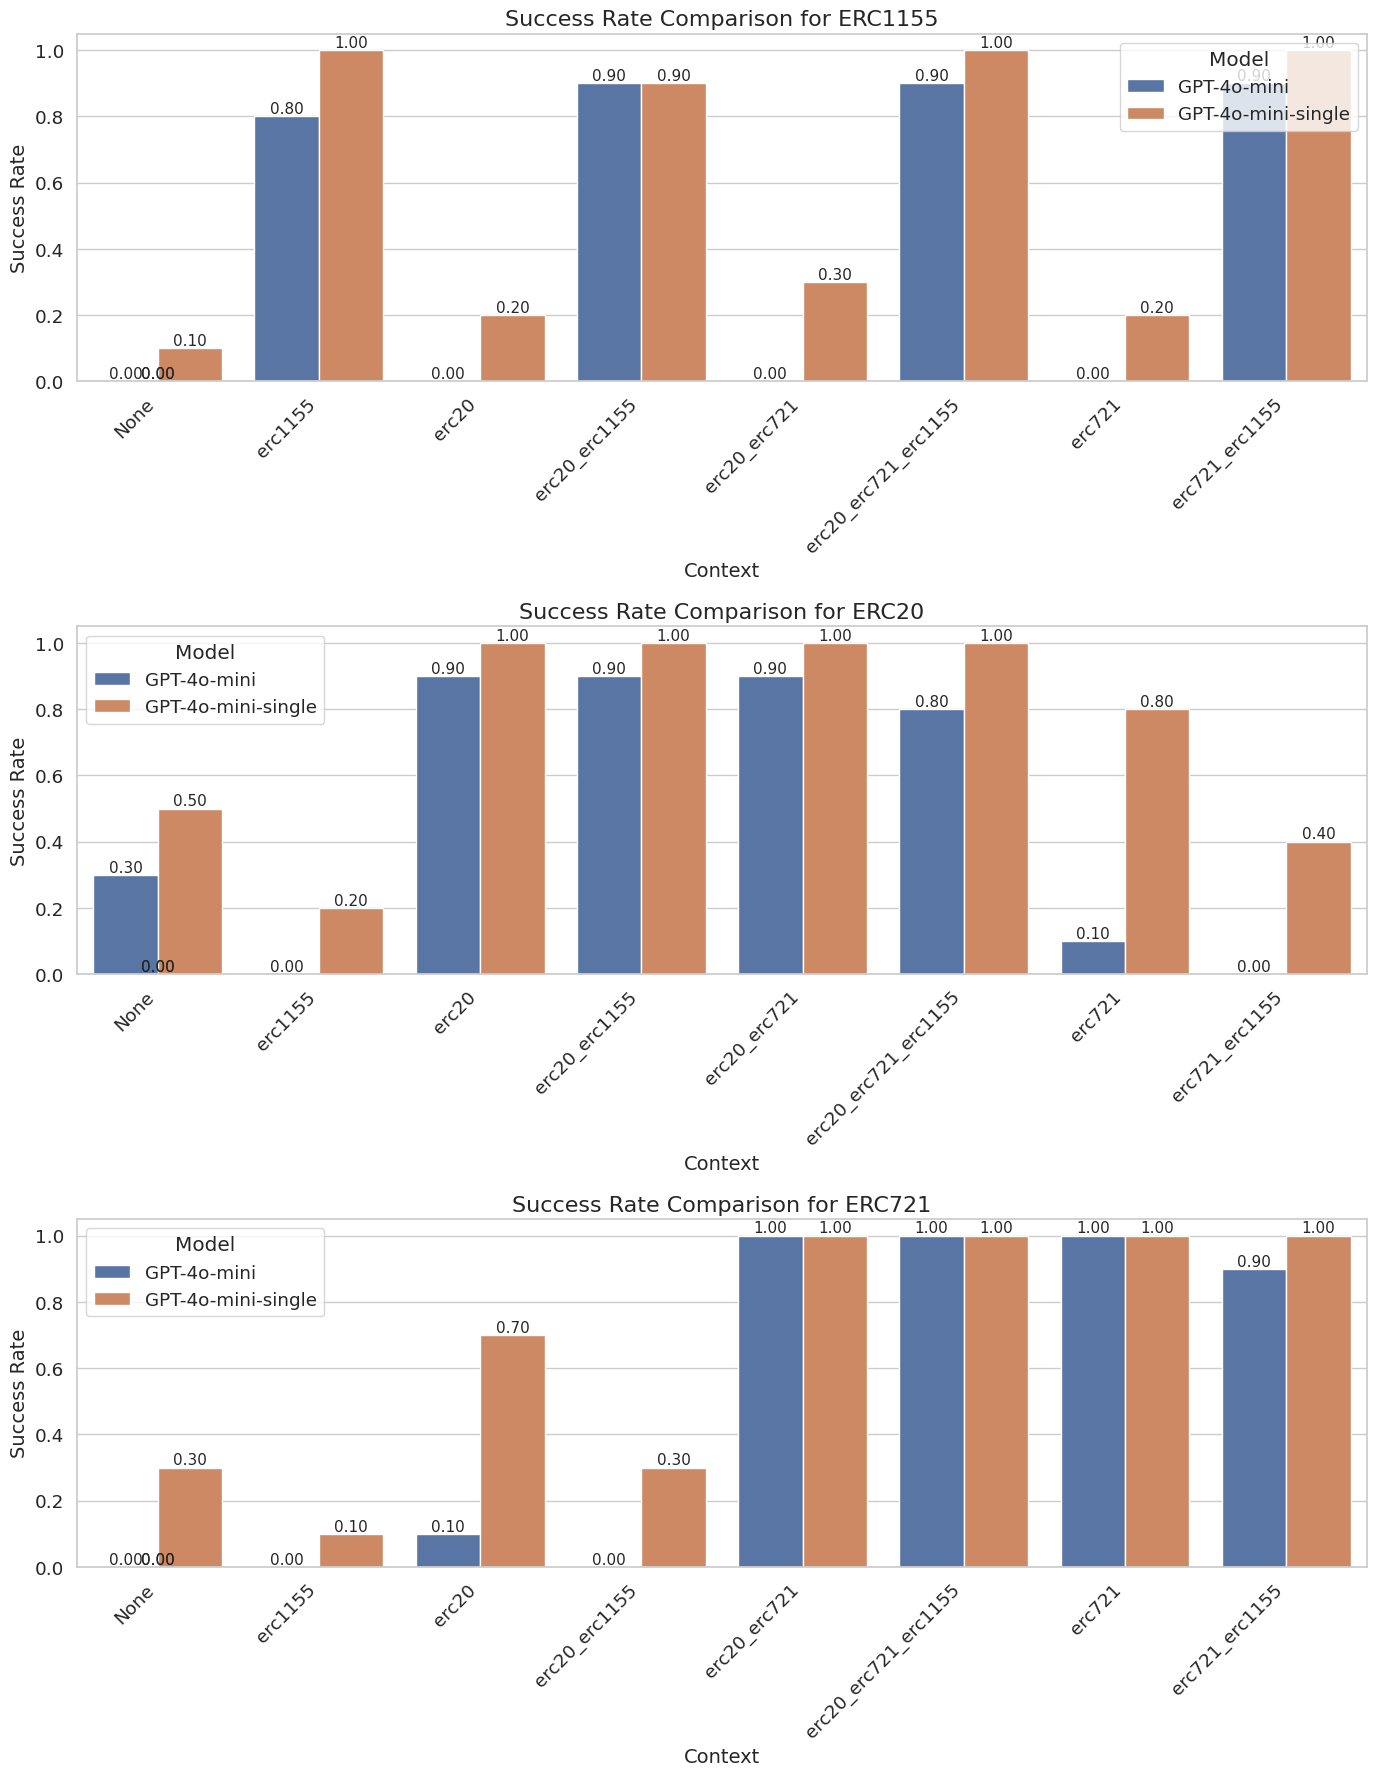

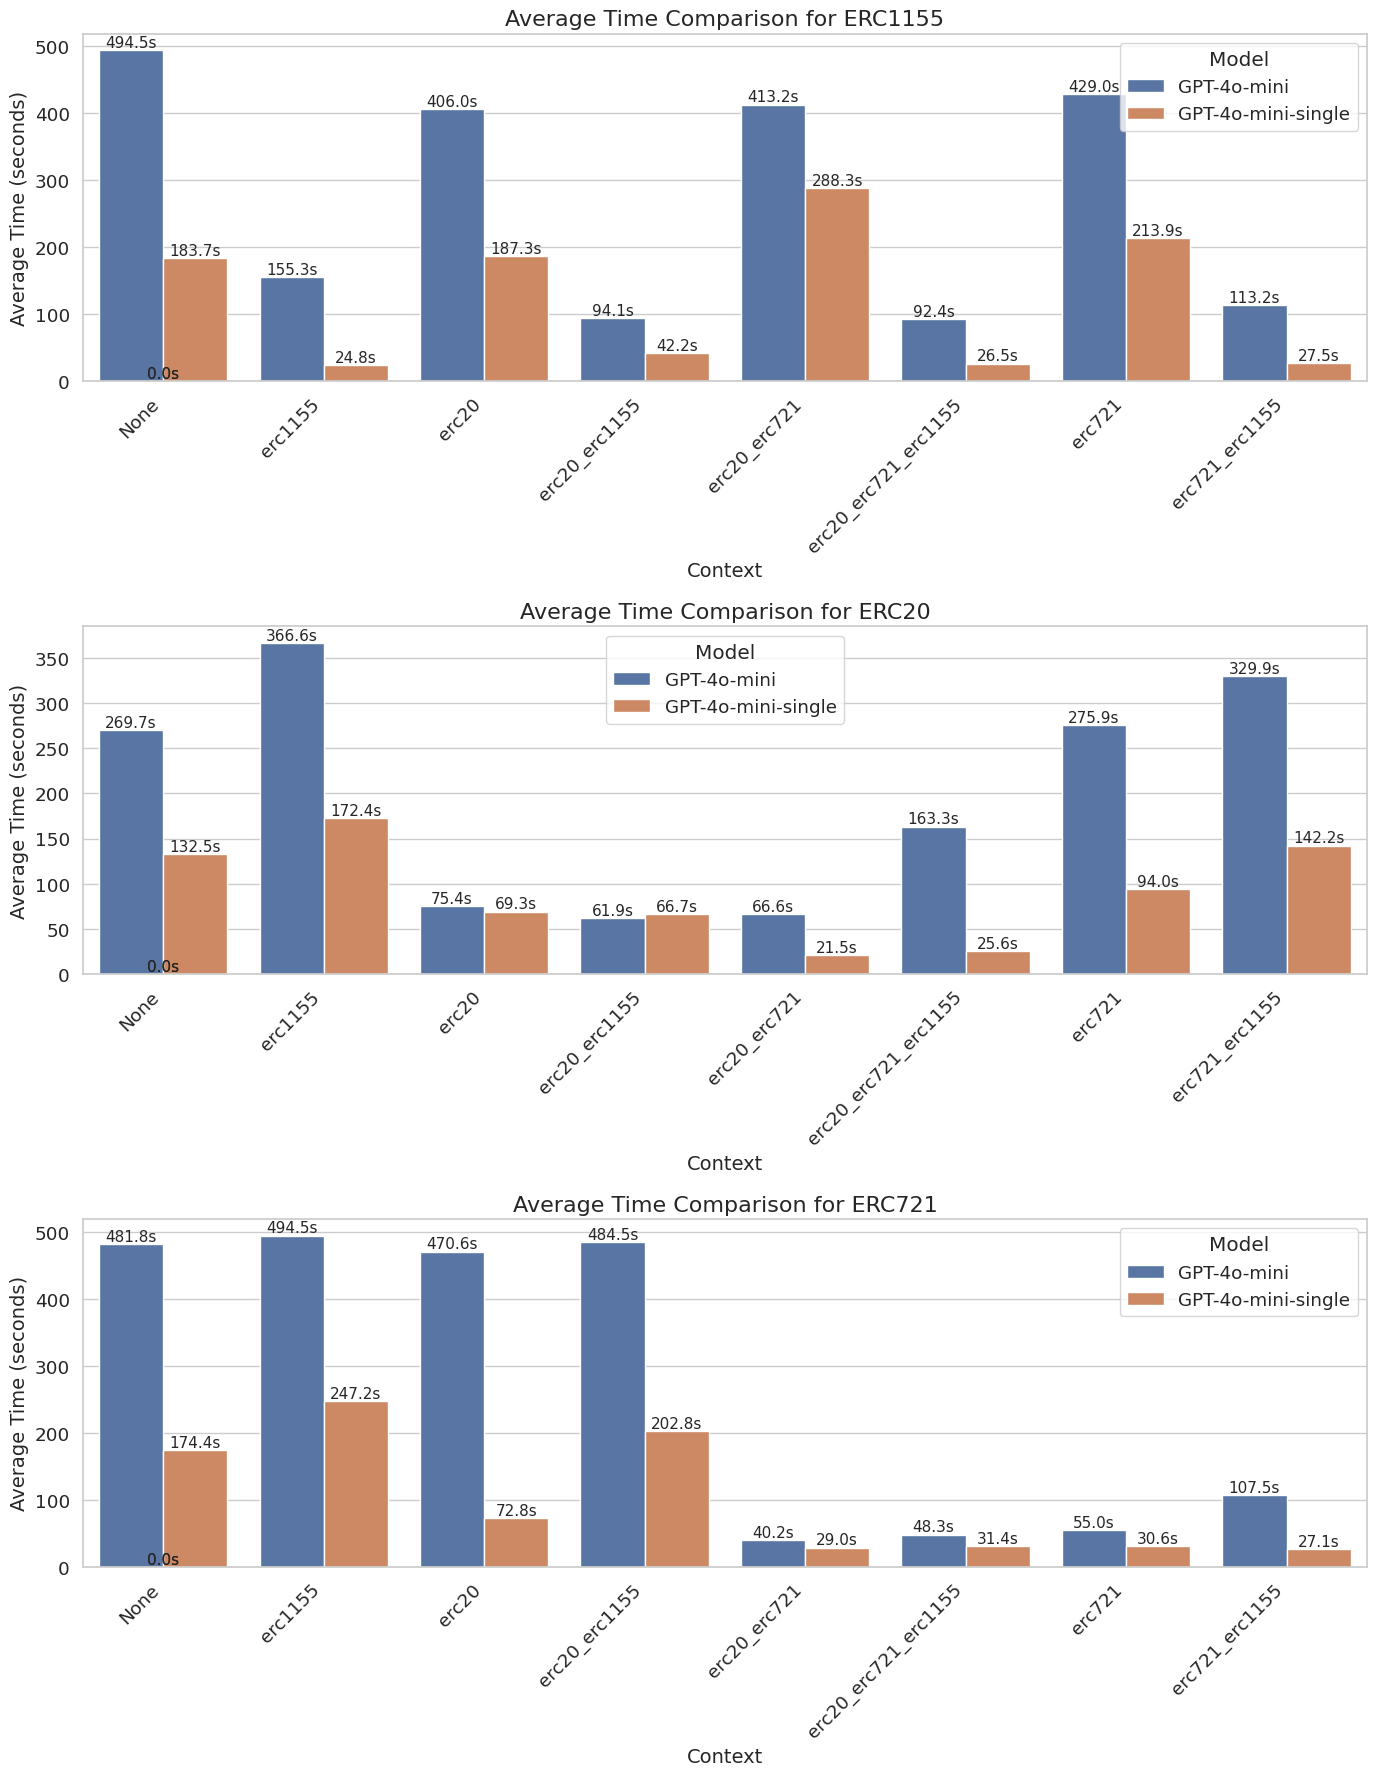

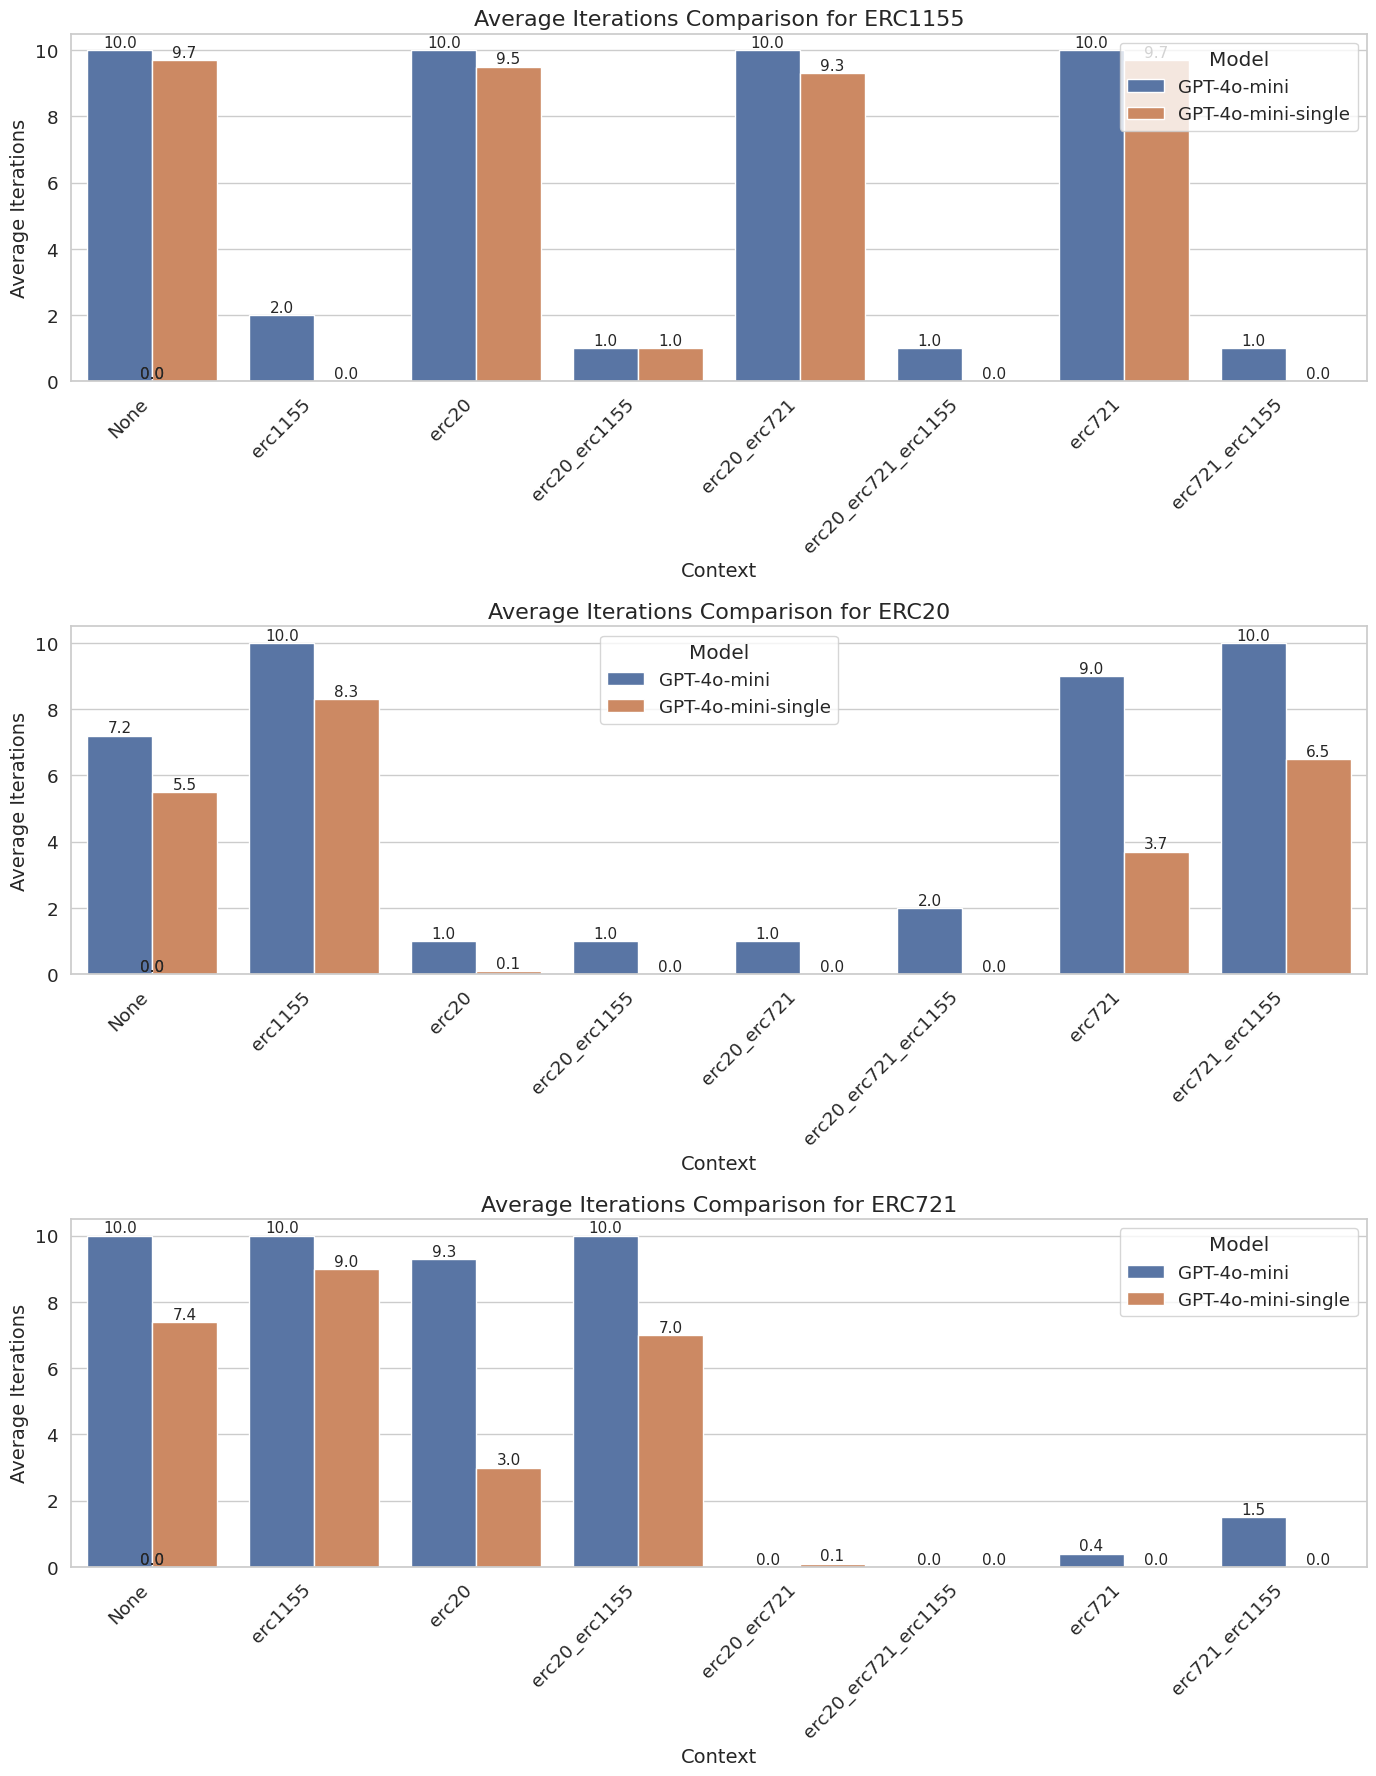

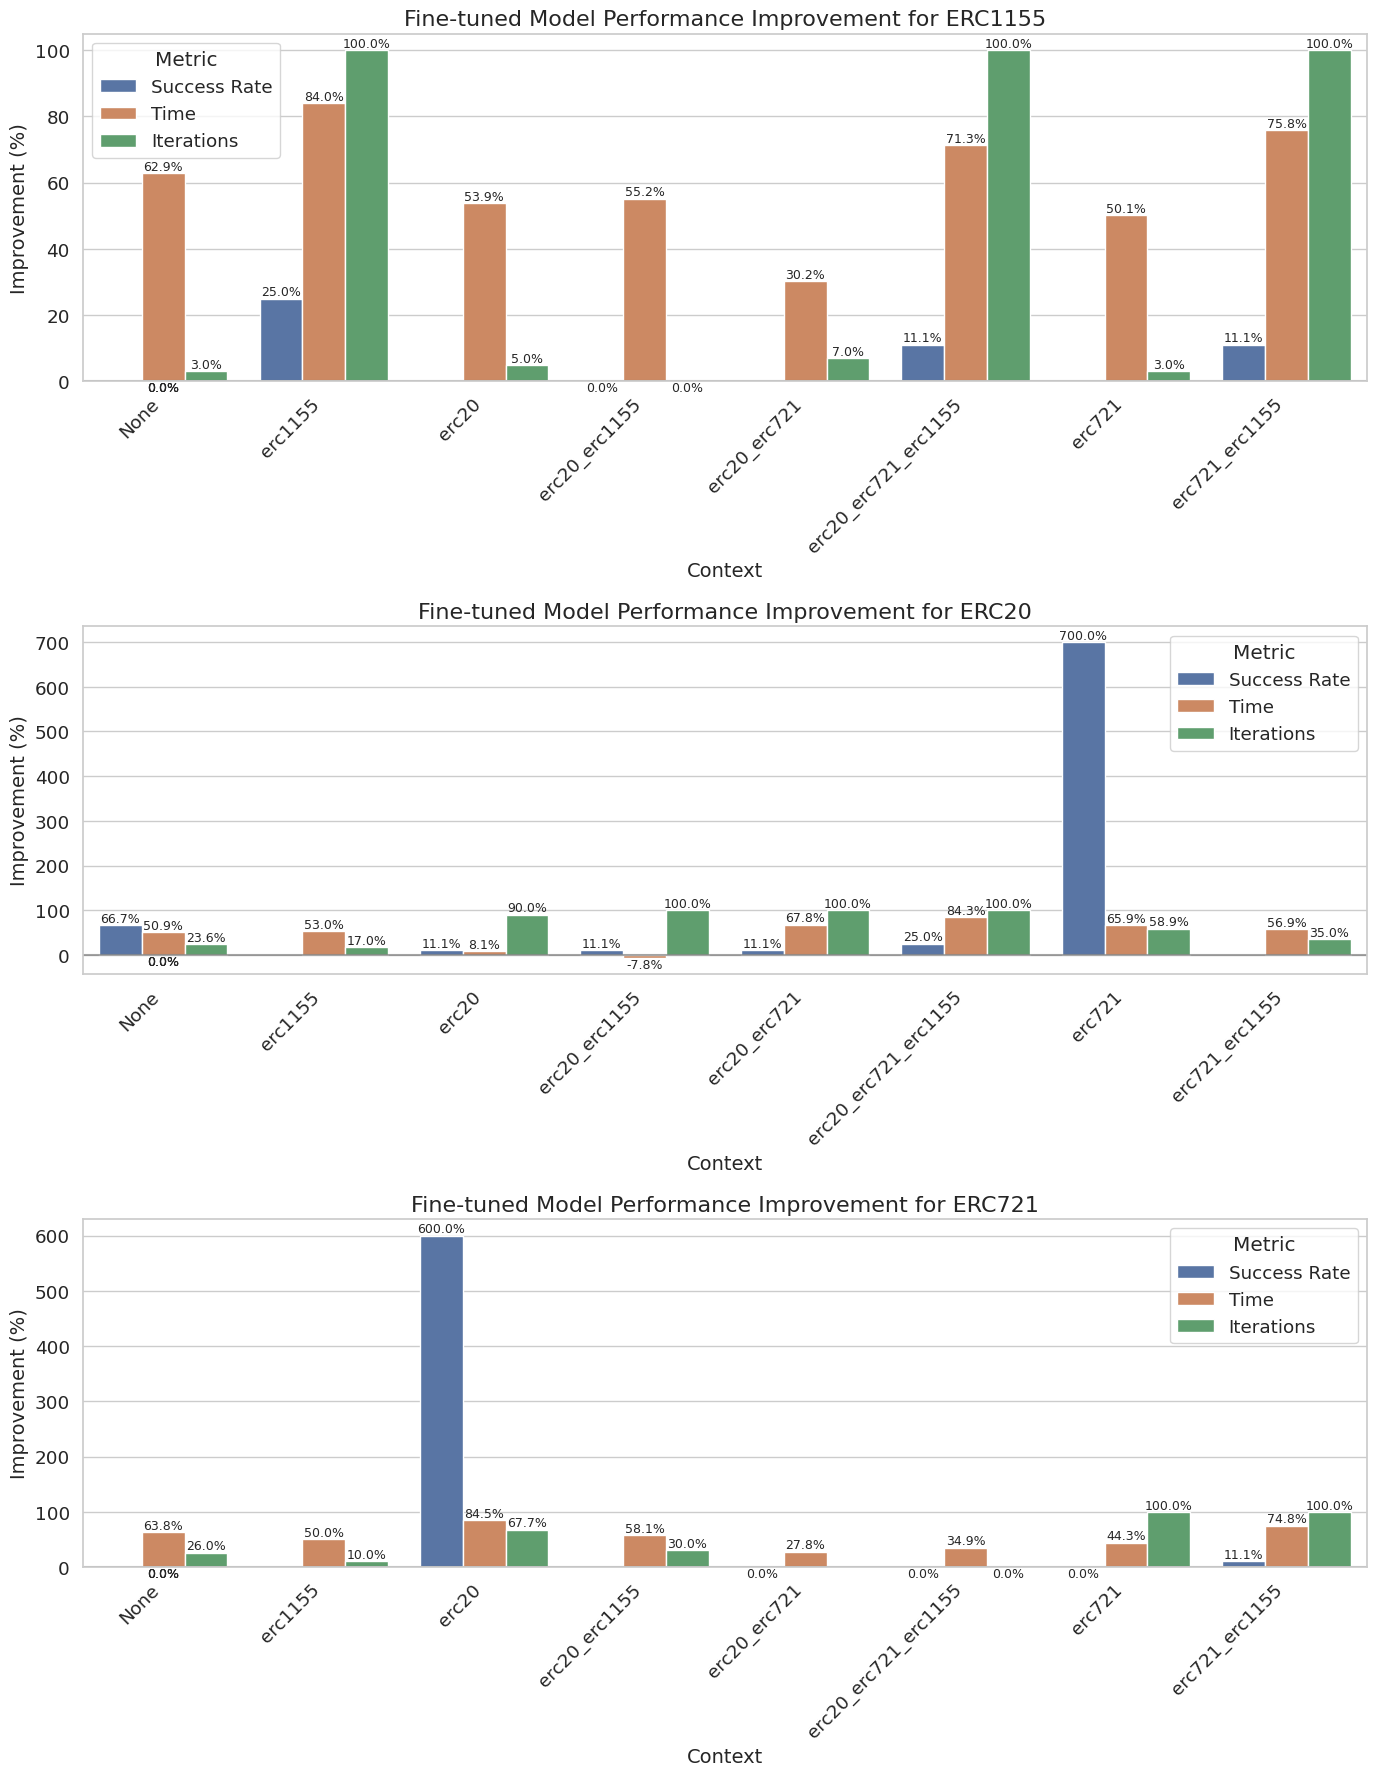

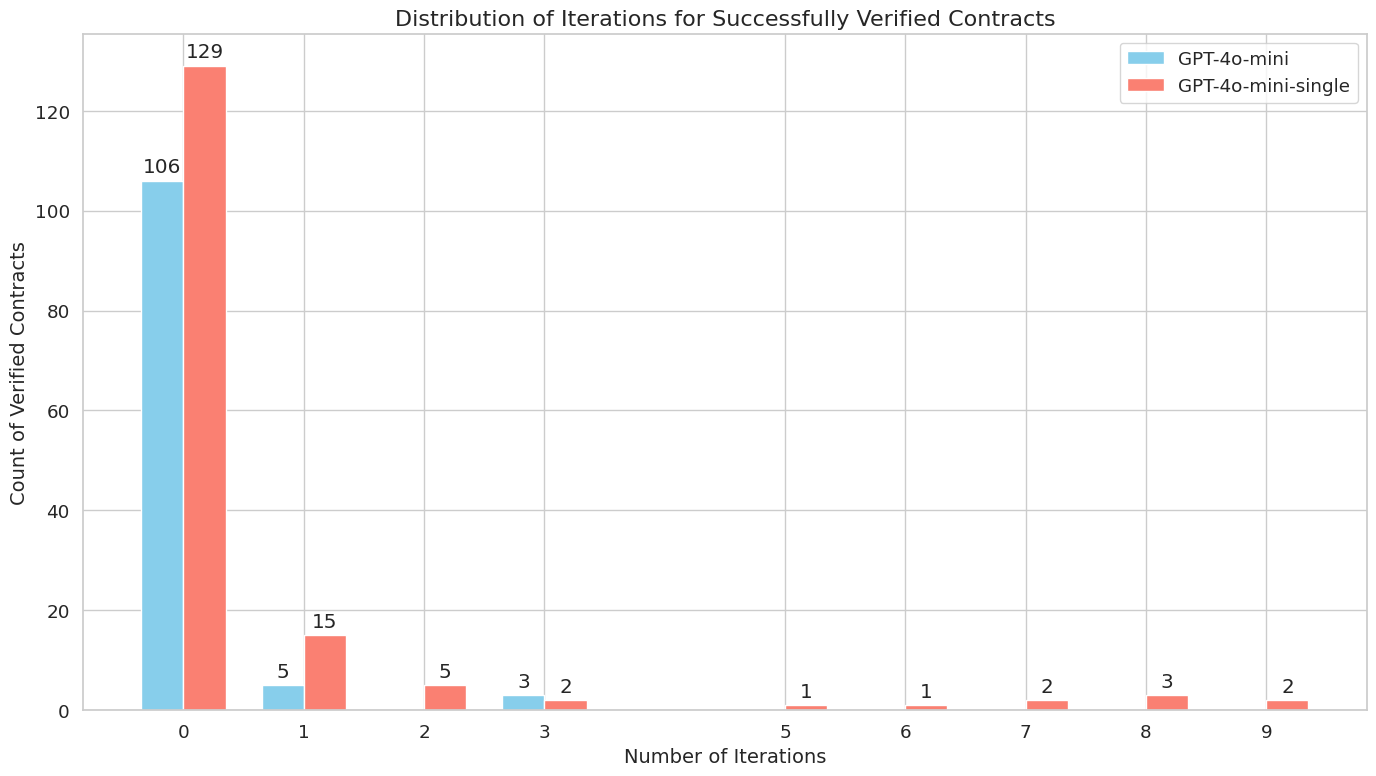

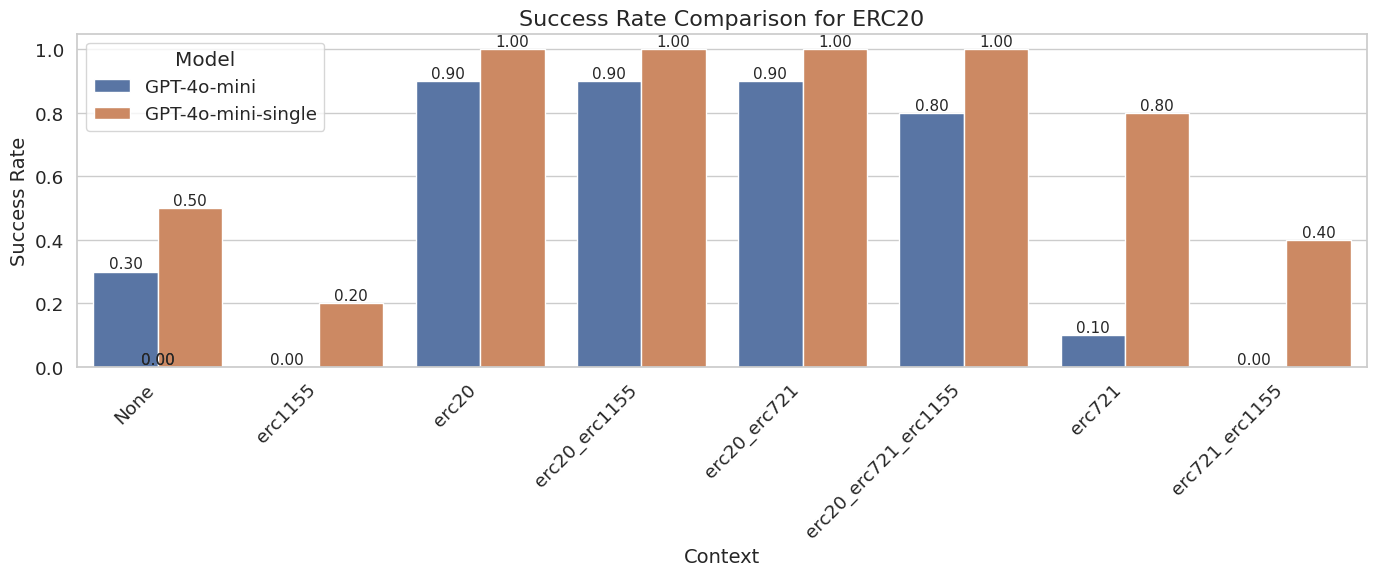

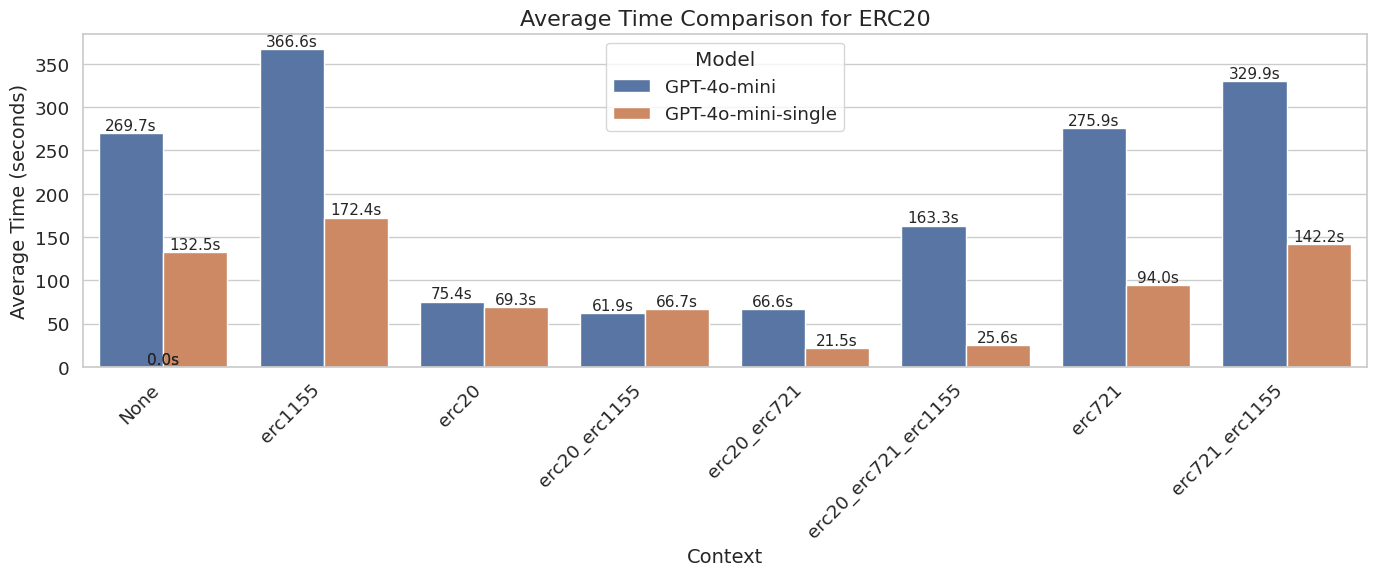

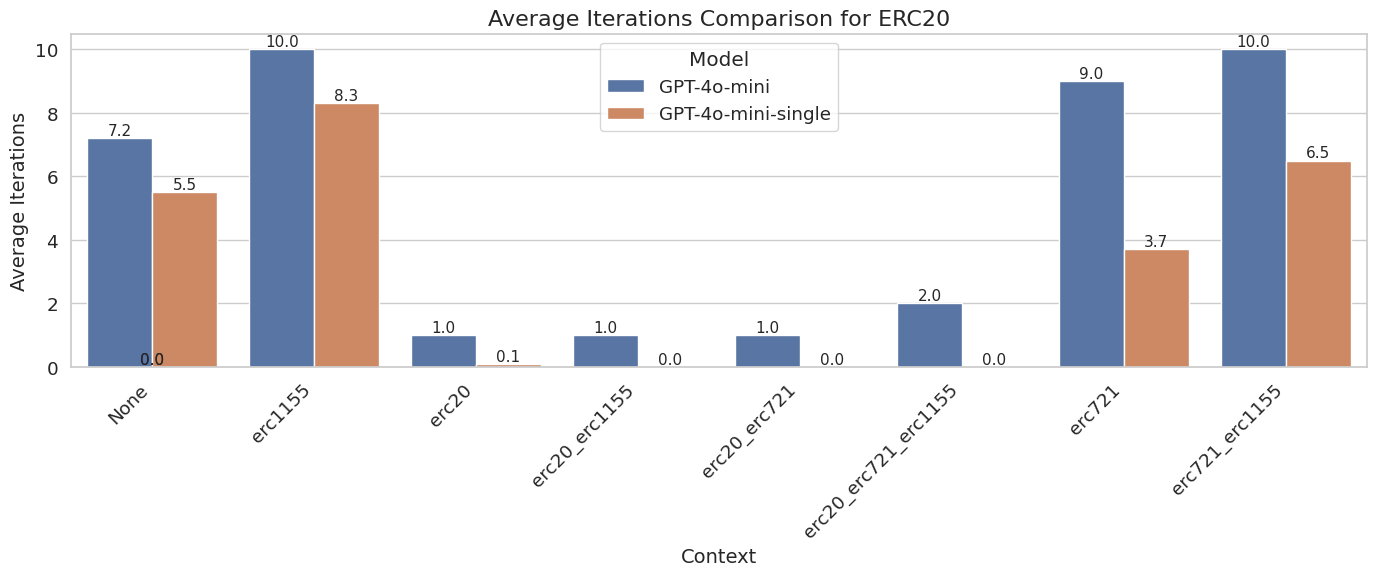

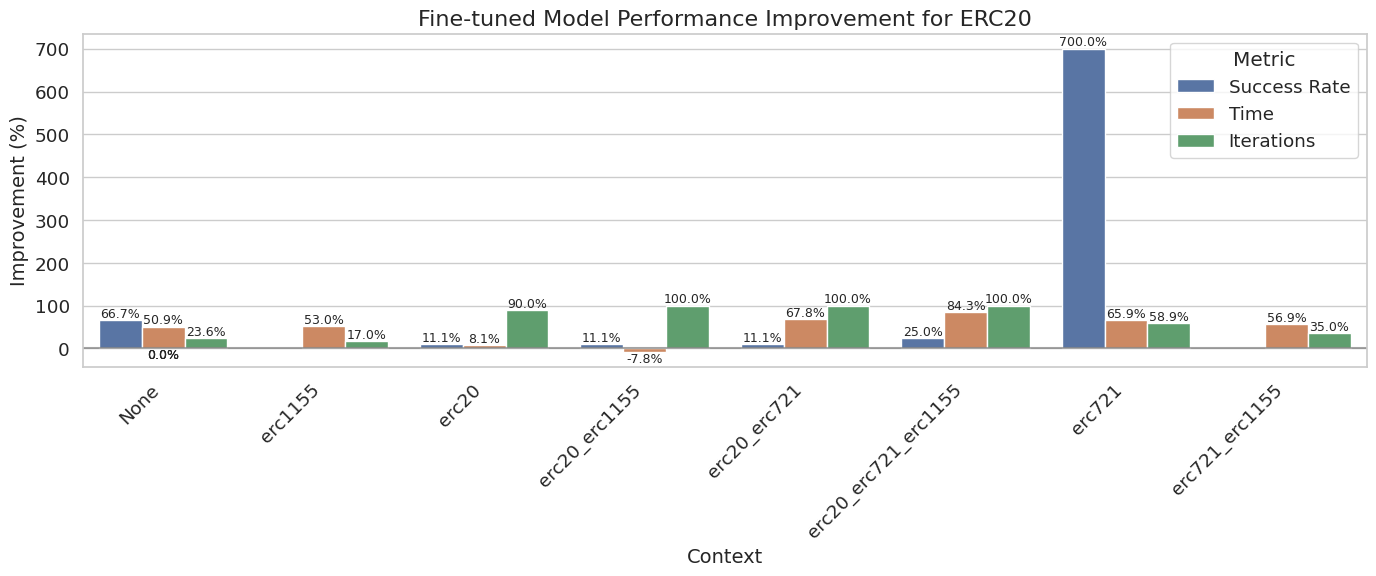

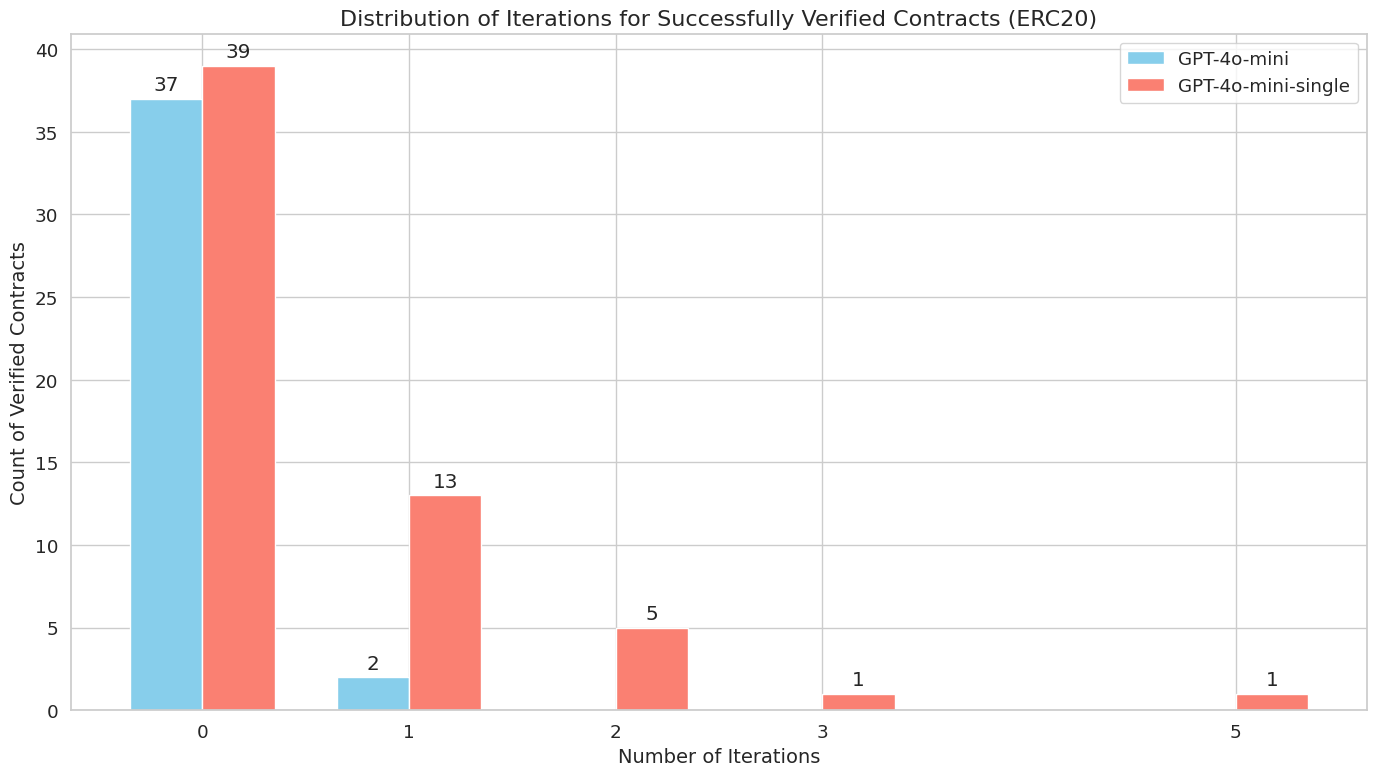

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import re
import json
from scipy import stats

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

class SmartContractVerificationAnalysis:
    """
    Comprehensive toolkit for analyzing smart contract verification results.
    Includes functionality for:
    1. General analysis across all contract types
    2. Model comparison (base vs. fine-tuned)
    3. Contract type-specific analysis (ERC20, ERC721, ERC1155)
    """
    
    def __init__(self, base_model_dir='results_4o_mini', fine_tuned_model_dir='results_4o_mini_single'):
        """
        Initialize the analysis toolkit.
        
        Parameters:
        -----------
        base_model_dir : str
            Directory containing base model results
        fine_tuned_model_dir : str
            Directory containing fine-tuned model results
        """
        self.base_model_dir = base_model_dir
        self.fine_tuned_model_dir = fine_tuned_model_dir
        self.data = {}
        self.combined_data = None
        
        # Dictionary to hold contract-specific data
        self.contract_data = {
            'erc20': None,
            'erc721': None,
            'erc1155': None
        }

    #---------------------------
    # DATA LOADING AND PROCESSING
    #---------------------------
    
    def load_all_data(self):
        """Load all CSV data from both model directories."""
        # Load base model data
        self.data['base'] = self._load_from_directory(self.base_model_dir, 'base')
        
        # Load fine-tuned model data
        self.data['fine_tuned'] = self._load_from_directory(self.fine_tuned_model_dir, 'fine_tuned')
        
        # Combine all data
        if self.data['base'] is not None and self.data['fine_tuned'] is not None:
            self.combined_data = pd.concat([self.data['base'], self.data['fine_tuned']], ignore_index=True)
            print(f"Combined data contains {len(self.combined_data)} rows")
            
            # Preprocess the combined data
            self.preprocess_data()
        else:
            print("Error loading data from one or both directories")
    
    def _load_from_directory(self, directory, model_label):
        """Load all CSV files from a directory."""
        all_data = []
        
        # Find all CSV files recursively
        csv_files = glob.glob(f"{directory}/**/*.csv", recursive=True)
        
        for file_path in csv_files:
            try:
                # Extract contract type and context from file path
                path_parts = Path(file_path).parts
                
                if len(path_parts) >= 3:
                    contract_type = path_parts[-3]  # erc20, erc721, erc1155
                    context = path_parts[-2]       # none, erc20, erc721, etc.
                else:
                    # Handle different directory structure if needed
                    contract_type = "unknown"
                    context = "unknown"
                
                # Read the CSV file
                df = pd.read_csv(file_path)
                
                # Add metadata columns
                df['model'] = model_label
                df['contract_type'] = contract_type
                df['context'] = context
                df['file_path'] = file_path
                
                # Append to our list
                all_data.append(df)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        
        if all_data:
            # Combine all dataframes
            combined_df = pd.concat(all_data, ignore_index=True)
            print(f"Loaded {len(all_data)} CSV files for {model_label} model with {len(combined_df)} total rows")
            return combined_df
        else:
            print(f"No CSV files found in {directory}")
            return None
    
    def load_contract_specific_data(self, contract_type):
        """Load data for a specific contract type (erc20, erc721, erc1155)."""
        if self.combined_data is None:
            print("No data loaded. Run load_all_data() first.")
            return None
        
        # Filter data for the specified contract type
        contract_data = self.combined_data[self.combined_data['contract_type'] == contract_type]
        
        if len(contract_data) > 0:
            self.contract_data[contract_type] = contract_data
            print(f"Loaded {len(contract_data)} rows for {contract_type}")
            return contract_data
        else:
            print(f"No data found for contract type: {contract_type}")
            return None
    
    def preprocess_data(self):
        """Clean and preprocess the data."""
        if self.combined_data is None:
            print("No data to preprocess. Run load_all_data() first.")
            return
        
        # Convert 'verified' column to boolean if it's not already
        if 'verified' in self.combined_data.columns:
            self.combined_data['verified'] = self.combined_data['verified'].astype(bool)
        
        # Extract numeric iterations value if it's stored as a string
        if 'iterations' in self.combined_data.columns and self.combined_data['iterations'].dtype == 'object':
            self.combined_data['iterations'] = pd.to_numeric(self.combined_data['iterations'], errors='coerce')
        
        # Clean up context names for better readability
        self.combined_data['context_clean'] = self.combined_data['context'].apply(
            lambda x: 'None' if x.lower() in ['none', ''] else x
        )
        
        # Add a human-readable model name
        self.combined_data['model_name'] = self.combined_data['model'].apply(
            lambda x: 'GPT-4o-mini' if x == 'base' else 'GPT-4o-mini-single'
        )
        
        # Create a combined experiment identifier
        self.combined_data['experiment'] = self.combined_data.apply(
            lambda row: f"{row['contract_type']}_{row['context_clean']}", axis=1
        )

    #---------------------------
    # GENERAL METRICS CALCULATION
    #---------------------------
    
    def calculate_metrics(self):
        """Calculate performance metrics for each model, contract type, and context."""
        if self.combined_data is None:
            print("No data to analyze. Run load_all_data() first.")
            return None
        
        # Group by model, contract type, and context
        grouped = self.combined_data.groupby(['model', 'contract_type', 'context_clean'])
        
        # Calculate metrics
        metrics = grouped.agg({
            'verified': ['mean', 'count', 'sum'],
            'time_taken': ['mean', 'median', 'std'],
            'iterations': ['mean', 'median', 'std']
        }).reset_index()
        
        # Flatten multi-level columns
        metrics.columns = ['_'.join(col).strip('_') for col in metrics.columns.values]
        
        # Rename columns for clarity
        metrics = metrics.rename(columns={
            'verified_mean': 'success_rate',
            'verified_count': 'num_runs',
            'verified_sum': 'successful_runs',
            'time_taken_mean': 'avg_time',
            'time_taken_median': 'median_time',
            'time_taken_std': 'std_time',
            'iterations_mean': 'avg_iterations',
            'iterations_median': 'median_iterations',
            'iterations_std': 'std_iterations'
        })
        
        return metrics
    
    def calculate_overall_metrics(self):
        """Calculate overall metrics by model."""
        metrics = self.calculate_metrics()
        
        if metrics is None:
            return None
        
        # Group by model and calculate overall metrics
        # First check the actual column name after flattening
        model_col = 'model_' if 'model_' in metrics.columns else 'model'
        
        # Group by the correct model column
        overall = metrics.groupby(model_col).agg({
            'success_rate': ['mean', 'std'],
            'avg_time': ['mean', 'std'],
            'avg_iterations': ['mean', 'std'],
            'num_runs': 'sum',
            'successful_runs': 'sum'
        }).reset_index()
        
        # Flatten multi-level columns
        overall.columns = ['_'.join(col).strip('_') for col in overall.columns.values]
        
        return overall
    
    def calculate_contract_metrics(self, contract_type):
        """Calculate metrics for a specific contract type."""
        # Load contract-specific data if not already loaded
        if self.contract_data[contract_type] is None:
            self.load_contract_specific_data(contract_type)
        
        if self.contract_data[contract_type] is None:
            return None
        
        # Group by model and context
        grouped = self.contract_data[contract_type].groupby(['model', 'context_clean'])
        
        # Calculate metrics
        metrics = grouped.agg({
            'verified': ['mean', 'count', 'sum'],
            'time_taken': ['mean', 'median', 'std'],
            'iterations': ['mean', 'median', 'std']
        }).reset_index()
        
        # Flatten multi-level columns
        metrics.columns = ['_'.join(col).strip('_') for col in metrics.columns.values]
        
        # Rename columns for clarity
        metrics = metrics.rename(columns={
            'verified_mean': 'success_rate',
            'verified_count': 'num_runs',
            'verified_sum': 'successful_runs',
            'time_taken_mean': 'avg_time',
            'time_taken_median': 'median_time',
            'time_taken_std': 'std_time',
            'iterations_mean': 'avg_iterations',
            'iterations_median': 'median_iterations',
            'iterations_std': 'std_iterations'
        })
        
        return metrics

    #---------------------------
    # MODEL COMPARISON ANALYSIS
    #---------------------------
    
    def create_comparative_metrics(self):
        """Create metrics that directly compare the two models."""
        metrics = self.calculate_metrics()
        
        if metrics is None:
            return None
            
        # Check the actual column name after flattening
        model_col = 'model_' if 'model_' in metrics.columns else 'model'
        
        # Pivot the data to have each experiment as a row and models as columns
        # For success rate
        comp_metrics = metrics.pivot_table(
            index=['contract_type', 'context_clean'],
            columns=model_col,
            values=['success_rate', 'avg_time', 'avg_iterations']
        ).reset_index()
        
        # Flatten hierarchical columns
        comp_metrics.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in comp_metrics.columns]
        
        # Calculate differences and improvement percentages
        comp_metrics['success_rate_diff'] = comp_metrics['success_rate_fine_tuned'] - comp_metrics['success_rate_base']
        comp_metrics['success_rate_improvement_pct'] = (comp_metrics['success_rate_diff'] / comp_metrics['success_rate_base'] * 100).fillna(0)
        
        comp_metrics['time_diff'] = comp_metrics['avg_time_base'] - comp_metrics['avg_time_fine_tuned']
        comp_metrics['time_improvement_pct'] = (comp_metrics['time_diff'] / comp_metrics['avg_time_base'] * 100).fillna(0)
        
        comp_metrics['iterations_diff'] = comp_metrics['avg_iterations_base'] - comp_metrics['avg_iterations_fine_tuned']
        comp_metrics['iterations_improvement_pct'] = (comp_metrics['iterations_diff'] / comp_metrics['avg_iterations_base'] * 100).fillna(0)
        
        # Create a combined experiment identifier
        comp_metrics['experiment'] = comp_metrics.apply(
            lambda row: f"{row['contract_type']}_{row['context_clean']}", axis=1
        )
        
        return comp_metrics
    
    def statistical_significance_test(self):
        """
        Run statistical significance tests comparing the performance of both models.
        Uses Mann-Whitney U test as a non-parametric test for comparing distributions.
        """
        if self.combined_data is None:
            print("No data to analyze. Run load_all_data() first.")
            return None
        
        # List to store statistical test results
        stats_results = []
        
        # Get unique experiment combinations
        experiments = self.combined_data.groupby(['contract_type', 'context_clean']).size().reset_index()[['contract_type', 'context_clean']]
        
        # For each experiment, perform statistical tests
        for _, exp in experiments.iterrows():
            contract_type = exp['contract_type']
            context = exp['context_clean']
            
            # Filter data for this experiment
            exp_data = self.combined_data[
                (self.combined_data['contract_type'] == contract_type) & 
                (self.combined_data['context_clean'] == context)
            ]
            
            # Split by model
            base_data = exp_data[exp_data['model'] == 'base']
            fine_tuned_data = exp_data[exp_data['model'] == 'fine_tuned']
            
            # Skip if any model has no data
            if len(base_data) == 0 or len(fine_tuned_data) == 0:
                continue
            
            # For verified (success rate)
            try:
                u_stat_verified, p_value_verified = stats.mannwhitneyu(
                    base_data['verified'].astype(int), 
                    fine_tuned_data['verified'].astype(int),
                    alternative='two-sided'
                )
            except:
                u_stat_verified, p_value_verified = np.nan, np.nan
            
            # For time taken
            try:
                u_stat_time, p_value_time = stats.mannwhitneyu(
                    base_data['time_taken'], 
                    fine_tuned_data['time_taken'],
                    alternative='two-sided'
                )
            except:
                u_stat_time, p_value_time = np.nan, np.nan
            
            # For iterations
            try:
                u_stat_iter, p_value_iter = stats.mannwhitneyu(
                    base_data['iterations'], 
                    fine_tuned_data['iterations'],
                    alternative='two-sided'
                )
            except:
                u_stat_iter, p_value_iter = np.nan, np.nan
            
            # Store results
            stats_results.append({
                'contract_type': contract_type,
                'context': context,
                'experiment': f"{contract_type}_{context}",
                'base_success_rate': base_data['verified'].mean(),
                'fine_tuned_success_rate': fine_tuned_data['verified'].mean(),
                'p_value_verified': p_value_verified,
                'significant_verified': p_value_verified < 0.05 if not np.isnan(p_value_verified) else False,
                
                'base_avg_time': base_data['time_taken'].mean(),
                'fine_tuned_avg_time': fine_tuned_data['time_taken'].mean(),
                'p_value_time': p_value_time,
                'significant_time': p_value_time < 0.05 if not np.isnan(p_value_time) else False,
                
                'base_avg_iterations': base_data['iterations'].mean(),
                'fine_tuned_avg_iterations': fine_tuned_data['iterations'].mean(),
                'p_value_iterations': p_value_iter,
                'significant_iterations': p_value_iter < 0.05 if not np.isnan(p_value_iter) else False
            })
        
        return pd.DataFrame(stats_results)
    
    def analyze_contract_content(self, contract_type, sample_size=5):
        """
        Analyze the content of verified contracts to identify patterns and common techniques.
        
        Parameters:
        -----------
        contract_type : str
            Type of contract to analyze ('erc20', 'erc721', 'erc1155')
        sample_size : int
            Number of verified contracts to sample for analysis
        """
        # Load contract-specific data if not already loaded
        if self.contract_data[contract_type] is None:
            self.load_contract_specific_data(contract_type)
        
        if self.contract_data[contract_type] is None:
            return None
        
        # Get a sample of verified contracts from each model
        contract_data = self.contract_data[contract_type]
        verified_base = contract_data[(contract_data['model'] == 'base') & (contract_data['verified'] == True)]
        verified_ft = contract_data[(contract_data['model'] == 'fine_tuned') & (contract_data['verified'] == True)]
        
        if len(verified_base) == 0 or len(verified_ft) == 0:
            print("Not enough verified contracts to analyze.")
            return None
        
        # Sample contracts
        base_sample = verified_base.sample(min(sample_size, len(verified_base)))
        ft_sample = verified_ft.sample(min(sample_size, len(verified_ft)))
        
        # Function to analyze postconditions
        def extract_postconditions(contract_text):
            if pd.isna(contract_text) or not isinstance(contract_text, str):
                return []
            
            # Extract postcondition lines
            post_pattern = r'///\s*@notice\s*postcondition\s*(.*)'
            postconditions = re.findall(post_pattern, contract_text)
            return postconditions
        
        # Analyze samples
        base_conditions = []
        for _, row in base_sample.iterrows():
            conditions = extract_postconditions(row['annotated_contract'])
            for cond in conditions:
                base_conditions.append({
                    'condition': cond,
                    'context': row['context_clean'],
                    'run': row['run']
                })
        
        ft_conditions = []
        for _, row in ft_sample.iterrows():
            conditions = extract_postconditions(row['annotated_contract'])
            for cond in conditions:
                ft_conditions.append({
                    'condition': cond,
                    'context': row['context_clean'],
                    'run': row['run']
                })
        
        # Count condition patterns
        def analyze_condition_patterns(conditions):
            patterns = {
                'state_reference': 0,  # References to state variables (_balances, _allowed, etc.)
                'old_reference': 0,    # References to __verifier_old_uint
                'self_transfer': 0,    # Special handling for self-transfers
                'return_checks': 0,    # Conditions with success/return value checks
                'math_operations': 0   # Mathematical operations
            }
            
            for cond in conditions:
                condition = cond['condition']
                
                # Check for state variable references
                if re.search(r'_balances|_allowed|_totalSupply|_owners|_tokenApprovals|_operatorApprovals|_balanceOf', condition):
                    patterns['state_reference'] += 1
                
                # Check for old state references
                if '__verifier_old_uint' in condition:
                    patterns['old_reference'] += 1
                
                # Check for self-transfer handling
                if re.search(r'==|!=|from\s*==|to\s*==|sender\s*==', condition):
                    patterns['self_transfer'] += 1
                
                # Check for return checks
                if re.search(r'success\s*\|\||&&\s*success|!\s*success', condition):
                    patterns['return_checks'] += 1
                
                # Check for math operations
                if re.search(r'\+|\-|\*|\/|<=|>=|<|>', condition):
                    patterns['math_operations'] += 1
            
            return patterns
        
        base_patterns = analyze_condition_patterns(base_conditions)
        ft_patterns = analyze_condition_patterns(ft_conditions)
        
        # Convert to percentage of total conditions
        base_total = len(base_conditions) or 1  # Avoid division by zero
        ft_total = len(ft_conditions) or 1
        
        base_percentages = {k: (v / base_total) * 100 for k, v in base_patterns.items()}
        ft_percentages = {k: (v / ft_total) * 100 for k, v in ft_patterns.items()}
        
        return {
            'base_conditions': base_conditions,
            'ft_conditions': ft_conditions,
            'base_patterns': base_patterns,
            'ft_patterns': ft_patterns,
            'base_percentages': base_percentages,
            'ft_percentages': ft_percentages
        }
    
    def analyze_iterations_pattern(self, contract_type=None):
        """
        Analyze the pattern of iterations to verify contracts.
        
        Parameters:
        -----------
        contract_type : str or None
            Type of contract to analyze (if None, analyze all contracts)
        """
        if self.combined_data is None:
            print("No data to analyze. Run load_all_data() first.")
            return None
        
        # Select data based on contract_type
        if contract_type is not None:
            if self.contract_data[contract_type] is None:
                self.load_contract_specific_data(contract_type)
            data = self.contract_data[contract_type]
        else:
            data = self.combined_data
        
        if data is None:
            return None
        
        # Focus on runs that eventually got verified
        verified_runs = data[data['verified'] == True]
        
        if len(verified_runs) == 0:
            print("No verified runs to analyze.")
            return None
        
        # Calculate statistics on iterations
        iterations_stats = {
            'base': {
                'min': verified_runs[verified_runs['model'] == 'base']['iterations'].min(),
                'max': verified_runs[verified_runs['model'] == 'base']['iterations'].max(),
                'mean': verified_runs[verified_runs['model'] == 'base']['iterations'].mean(),
                'median': verified_runs[verified_runs['model'] == 'base']['iterations'].median(),
                'std': verified_runs[verified_runs['model'] == 'base']['iterations'].std()
            },
            'fine_tuned': {
                'min': verified_runs[verified_runs['model'] == 'fine_tuned']['iterations'].min(),
                'max': verified_runs[verified_runs['model'] == 'fine_tuned']['iterations'].max(),
                'mean': verified_runs[verified_runs['model'] == 'fine_tuned']['iterations'].mean(),
                'median': verified_runs[verified_runs['model'] == 'fine_tuned']['iterations'].median(),
                'std': verified_runs[verified_runs['model'] == 'fine_tuned']['iterations'].std()
            }
        }
        
        # Group by iterations and count
        iterations_dist = {
            'base': verified_runs[verified_runs['model'] == 'base']['iterations'].value_counts().sort_index().to_dict(),
            'fine_tuned': verified_runs[verified_runs['model'] == 'fine_tuned']['iterations'].value_counts().sort_index().to_dict()
        }
        
        return {
            'stats': iterations_stats,
            'distribution': iterations_dist
        }
    
    def analyze_time_performance(self, contract_type=None):
        """
        Analyze the time performance for different iterations.
        
        Parameters:
        -----------
        contract_type : str or None
            Type of contract to analyze (if None, analyze all contracts)
        """
        if self.combined_data is None:
            print("No data to analyze. Run load_all_data() first.")
            return None
        
        # Select data based on contract_type
        if contract_type is not None:
            if self.contract_data[contract_type] is None:
                self.load_contract_specific_data(contract_type)
            data = self.contract_data[contract_type]
        else:
            data = self.combined_data
        
        if data is None:
            return None
        
        # Prepare data for analysis
        time_iterations_data = data[['model', 'iterations', 'time_taken', 'verified']]
        
        # Group by model and iterations
        grouped = time_iterations_data.groupby(['model', 'iterations']).agg({
            'time_taken': ['mean', 'median', 'std', 'count'],
            'verified': ['mean', 'sum']
        }).reset_index()
        
        # Flatten multi-level columns
        grouped.columns = ['_'.join(col).strip('_') for col in grouped.columns.values]
        
        # Rename for clarity
        grouped = grouped.rename(columns={
            'time_taken_mean': 'avg_time',
            'time_taken_median': 'median_time',
            'time_taken_std': 'std_time',
            'time_taken_count': 'num_runs',
            'verified_mean': 'success_rate',
            'verified_sum': 'successful_runs'
        })
        
        # Add time per iteration
        grouped['time_per_iteration'] = grouped['avg_time'] / grouped['iterations_']
        
        return grouped

    #---------------------------
    # VISUALIZATION FUNCTIONS
    #---------------------------
    
    def plot_success_rate_comparison(self, save_path=None, contract_type=None):
        """
        Plot success rate comparison between models by contract type and context.
        
        Parameters:
        -----------
        save_path : str or None
            Path to save the figure
        contract_type : str or None
            If provided, only plot data for this contract type
        """
        metrics = self.calculate_metrics()
        
        if metrics is None:
            return None
            
        # Check the actual column name after flattening
        model_col = 'model_' if 'model_' in metrics.columns else 'model'
        
        # Filter by contract type if specified
        if contract_type:
            metrics = metrics[metrics['contract_type'] == contract_type]
            if len(metrics) == 0:
                print(f"No data for contract type: {contract_type}")
                return None
        
        # Get unique contract types
        contract_types = metrics['contract_type'].unique()
        
        # Create figure with subplots
        fig, axes = plt.subplots(len(contract_types), 1, figsize=(14, 6 * len(contract_types)))
        
        # Handle single subplot case
        if len(contract_types) == 1:
            axes = [axes]
        
        # For each contract type
        for i, ct in enumerate(contract_types):
            # Filter data for this contract type
            contract_data = metrics[metrics['contract_type'] == ct]
            
            # Get unique contexts
            contexts = sorted(contract_data['context_clean'].unique())
            
            # Prepare data for plotting
            plot_data = []
            for context in contexts:
                for model in ['base', 'fine_tuned']:
                    row = contract_data[(contract_data['context_clean'] == context) & 
                                         (contract_data[model_col] == model)]
                    if not row.empty:
                        plot_data.append({
                            'Context': context,
                            'Success Rate': row['success_rate'].values[0],
                            'Model': 'GPT-4o-mini' if model == 'base' else 'GPT-4o-mini-single'
                        })
            
            plot_df = pd.DataFrame(plot_data)
            
            # Create the bar chart
            sns.barplot(
                x='Context', 
                y='Success Rate', 
                hue='Model', 
                data=plot_df,
                ax=axes[i]
            )
            
            # Add labels and title
            axes[i].set_title(f'Success Rate Comparison for {ct.upper()}', fontsize=16)
            axes[i].set_xlabel('Context', fontsize=14)
            axes[i].set_ylabel('Success Rate', fontsize=14)
            axes[i].set_ylim(0, 1.05)
            
            # Add value labels
            for p in axes[i].patches:
                axes[i].annotate(
                    f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    fontsize=11
                )
            
            # Rotate x-axis labels
            plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure if path provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Success rate comparison saved to {save_path}")
        
        return fig
    
    def plot_time_comparison(self, save_path=None, contract_type=None):
        """
        Plot time comparison between models by contract type and context.
        
        Parameters:
        -----------
        save_path : str or None
            Path to save the figure
        contract_type : str or None
            If provided, only plot data for this contract type
        """
        metrics = self.calculate_metrics()
        
        if metrics is None:
            return None
            
        # Check the actual column name after flattening
        model_col = 'model_' if 'model_' in metrics.columns else 'model'
        
        # Filter by contract type if specified
        if contract_type:
            metrics = metrics[metrics['contract_type'] == contract_type]
            if len(metrics) == 0:
                print(f"No data for contract type: {contract_type}")
                return None
        
        # Get unique contract types
        contract_types = metrics['contract_type'].unique()
        
        # Create figure with subplots
        fig, axes = plt.subplots(len(contract_types), 1, figsize=(14, 6 * len(contract_types)))
        
        # Handle single subplot case
        if len(contract_types) == 1:
            axes = [axes]
        
        # For each contract type
        for i, ct in enumerate(contract_types):
            # Filter data for this contract type
            contract_data = metrics[metrics['contract_type'] == ct]
            
            # Get unique contexts
            contexts = sorted(contract_data['context_clean'].unique())
            
            # Prepare data for plotting
            plot_data = []
            for context in contexts:
                for model in ['base', 'fine_tuned']:
                    row = contract_data[(contract_data['context_clean'] == context) & 
                                         (contract_data[model_col] == model)]
                    if not row.empty:
                        plot_data.append({
                            'Context': context,
                            'Average Time (s)': row['avg_time'].values[0],
                            'Model': 'GPT-4o-mini' if model == 'base' else 'GPT-4o-mini-single'
                        })
            
            plot_df = pd.DataFrame(plot_data)
            
            # Create the bar chart
            sns.barplot(
                x='Context', 
                y='Average Time (s)', 
                hue='Model', 
                data=plot_df,
                ax=axes[i]
            )
            
            # Add labels and title
            axes[i].set_title(f'Average Time Comparison for {ct.upper()}', fontsize=16)
            axes[i].set_xlabel('Context', fontsize=14)
            axes[i].set_ylabel('Average Time (seconds)', fontsize=14)
            
            # Add value labels
            for p in axes[i].patches:
                axes[i].annotate(
                    f"{p.get_height():.1f}s",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    fontsize=11
                )
            
            # Rotate x-axis labels
            plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure if path provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Time comparison saved to {save_path}")
        
        return fig
    
    def plot_iterations_comparison(self, save_path=None, contract_type=None):
        """
        Plot iterations comparison between models by contract type and context.
        
        Parameters:
        -----------
        save_path : str or None
            Path to save the figure
        contract_type : str or None
            If provided, only plot data for this contract type
        """
        metrics = self.calculate_metrics()
        
        if metrics is None:
            return None
            
        # Check the actual column name after flattening
        model_col = 'model_' if 'model_' in metrics.columns else 'model'
        
        # Filter by contract type if specified
        if contract_type:
            metrics = metrics[metrics['contract_type'] == contract_type]
            if len(metrics) == 0:
                print(f"No data for contract type: {contract_type}")
                return None
        
        # Get unique contract types
        contract_types = metrics['contract_type'].unique()
        
        # Create figure with subplots
        fig, axes = plt.subplots(len(contract_types), 1, figsize=(14, 6 * len(contract_types)))
        
        # Handle single subplot case
        if len(contract_types) == 1:
            axes = [axes]
        
        # For each contract type
        for i, ct in enumerate(contract_types):
            # Filter data for this contract type
            contract_data = metrics[metrics['contract_type'] == ct]
            
            # Get unique contexts
            contexts = sorted(contract_data['context_clean'].unique())
            
            # Prepare data for plotting
            plot_data = []
            for context in contexts:
                for model in ['base', 'fine_tuned']:
                    row = contract_data[(contract_data['context_clean'] == context) & 
                                         (contract_data[model_col] == model)]
                    if not row.empty:
                        plot_data.append({
                            'Context': context,
                            'Average Iterations': row['avg_iterations'].values[0],
                            'Model': 'GPT-4o-mini' if model == 'base' else 'GPT-4o-mini-single'
                        })
            
            plot_df = pd.DataFrame(plot_data)
            
            # Create the bar chart
            sns.barplot(
                x='Context', 
                y='Average Iterations', 
                hue='Model', 
                data=plot_df,
                ax=axes[i]
            )
            
            # Add labels and title
            axes[i].set_title(f'Average Iterations Comparison for {ct.upper()}', fontsize=16)
            axes[i].set_xlabel('Context', fontsize=14)
            axes[i].set_ylabel('Average Iterations', fontsize=14)
            
            # Add value labels
            for p in axes[i].patches:
                axes[i].annotate(
                    f"{p.get_height():.1f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom',
                    fontsize=11
                )
            
            # Rotate x-axis labels
            plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure if path provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Iterations comparison saved to {save_path}")
        
        return fig
    
    def plot_improvement_chart(self, save_path=None, contract_type=None):
        """
        Plot the improvement of the fine-tuned model over the base model.
        
        Parameters:
        -----------
        save_path : str or None
            Path to save the figure
        contract_type : str or None
            If provided, only plot data for this contract type
        """
        comp_metrics = self.create_comparative_metrics()
        
        if comp_metrics is None:
            return None
        
        # Filter by contract type if specified
        if contract_type:
            comp_metrics = comp_metrics[comp_metrics['contract_type'] == contract_type]
            if len(comp_metrics) == 0:
                print(f"No data for contract type: {contract_type}")
                return None
        
        # Get unique contract types
        contract_types = comp_metrics['contract_type'].unique()
        
        # Create figure with subplots
        fig, axes = plt.subplots(len(contract_types), 1, figsize=(14, 6 * len(contract_types)))
        
        # Handle single subplot case
        if len(contract_types) == 1:
            axes = [axes]
        
        # For each contract type
        for i, ct in enumerate(contract_types):
            # Filter data for this contract type
            contract_data = comp_metrics[comp_metrics['contract_type'] == ct]
            
            # Melt the data for plotting
            plot_data = pd.melt(
                contract_data,
                id_vars=['context_clean'],
                value_vars=['success_rate_improvement_pct', 'time_improvement_pct', 'iterations_improvement_pct'],
                var_name='Metric',
                value_name='Improvement (%)'
            )
            
            # Clean metric names
            plot_data['Metric'] = plot_data['Metric'].map({
                'success_rate_improvement_pct': 'Success Rate',
                'time_improvement_pct': 'Time',
                'iterations_improvement_pct': 'Iterations'
            })
            
            # Create the grouped bar chart
            sns.barplot(
                x='context_clean',
                y='Improvement (%)',
                hue='Metric',
                data=plot_data,
                ax=axes[i]
            )
            
            # Add horizontal line at 0%
            axes[i].axhline(y=0, color='gray', linestyle='-', alpha=0.7)
            
            # Add labels and title
            axes[i].set_title(f'Fine-tuned Model Performance Improvement for {ct.upper()}', fontsize=16)
            axes[i].set_xlabel('Context', fontsize=14)
            axes[i].set_ylabel('Improvement (%)', fontsize=14)
            
            # Add legend
            axes[i].legend(title='Metric')
            
            # Add value labels on bars
            for p in axes[i].patches:
                axes[i].annotate(
                    f"{p.get_height():.1f}%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom' if p.get_height() > 0 else 'top',
                    fontsize=9
                )
            
            # Rotate x-axis labels
            plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure if path provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Improvement chart saved to {save_path}")
        
        return fig
    
    def plot_iterations_distribution(self, save_path=None, contract_type=None):
        """
        Plot distribution of iterations for successful verifications.
        
        Parameters:
        -----------
        save_path : str or None
            Path to save the figure
        contract_type : str or None
            If provided, only plot data for this contract type
        """
        iterations_data = self.analyze_iterations_pattern(contract_type)
        
        if iterations_data is None:
            return None
        
        # Get distributions
        base_dist = iterations_data['distribution']['base']
        ft_dist = iterations_data['distribution']['fine_tuned']
        
        # Create lists of iterations and counts
        base_iters = list(base_dist.keys())
        base_counts = list(base_dist.values())
        ft_iters = list(ft_dist.keys())
        ft_counts = list(ft_dist.values())
        
        # Create figure
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Set width for bars
        width = 0.35
        
        # Create bars for base model
        rects1 = ax.bar(
            np.array(base_iters) - width/2, 
            base_counts, 
            width, 
            label='GPT-4o-mini',
            color='skyblue'
        )
        
        # Create bars for fine-tuned model
        rects2 = ax.bar(
            np.array(ft_iters) + width/2, 
            ft_counts, 
            width, 
            label='GPT-4o-mini-single',
            color='salmon'
        )
        
        # Add labels and title
        title = f'Distribution of Iterations for Successfully Verified Contracts'
        if contract_type:
            title += f' ({contract_type.upper()})'
        
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('Number of Iterations', fontsize=14)
        ax.set_ylabel('Count of Verified Contracts', fontsize=14)
        ax.legend()
        
        # Set x-ticks to be integers
        all_iters = sorted(list(set(base_iters + ft_iters)))
        ax.set_xticks(all_iters)
        ax.set_xticklabels(all_iters)
        
        # Add annotations
        for rect in rects1:
            height = rect.get_height()
            if height > 0:
                ax.annotate(
                    f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                )
        
        for rect in rects2:
            height = rect.get_height()
            if height > 0:
                ax.annotate(
                    f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom'
                )
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure if path provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Iterations distribution saved to {save_path}")
        
        return fig
    
    def plot_pattern_comparison(self, contract_type, save_path=None):
        """
        Plot comparison of contract patterns between models.
        
        Parameters:
        -----------
        contract_type : str
            Type of contract to analyze ('erc20', 'erc721', 'erc1155')
        save_path : str or None
            Path to save the figure
        """
        content_analysis = self.analyze_contract_content(contract_type)
        
        if content_analysis is None:
            return None
        
        # Get percentages
        base_pct = content_analysis['base_percentages']
        ft_pct = content_analysis['ft_percentages']
        
        # Prepare data for plotting
        patterns = list(base_pct.keys())
        base_values = [base_pct[p] for p in patterns]
        ft_values = [ft_pct[p] for p in patterns]
        
        # Clean up pattern names for display
        pattern_labels = [p.replace('_', ' ').title() for p in patterns]
        
        # Create figure
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Set width for bars
        width = 0.35
        
        # Create x positions
        x = np.arange(len(patterns))
        
        # Create bars
        rects1 = ax.bar(x - width/2, base_values, width, label='GPT-4o-mini', color='skyblue')
        rects2 = ax.bar(x + width/2, ft_values, width, label='GPT-4o-mini-single', color='salmon')
        
        # Add labels and title
        ax.set_title(f'Comparison of Verification Condition Patterns in {contract_type.upper()} Contracts', fontsize=16)
        ax.set_xlabel('Pattern Type', fontsize=14)
        ax.set_ylabel('Percentage of Conditions (%)', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(pattern_labels)
        ax.legend()
        
        # Add value annotations
        for rect in rects1:
            height = rect.get_height()
            ax.annotate(
                f'{height:.1f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom'
            )
        
        for rect in rects2:
            height = rect.get_height()
            ax.annotate(
                f'{height:.1f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom'
            )
        
        # Adjust layout
        plt.tight_layout()
        
        # Save figure if path provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Pattern comparison chart saved to {save_path}")
        
        return fig

    #---------------------------
    # COMPREHENSIVE REPORTS
    #---------------------------
    
    def generate_model_comparison_report(self, output_dir='model_comparison_results'):
        """
        Generate a comprehensive HTML report comparing the base and fine-tuned models.
        
        Parameters:
        -----------
        output_dir : str
            Directory to save the report and associated files
        """
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Make sure data is loaded
        if self.combined_data is None:
            self.load_all_data()
        
        # Calculate metrics
        metrics = self.calculate_metrics()
        comp_metrics = self.create_comparative_metrics()
        stats_results = self.statistical_significance_test()
        
        if metrics is None or comp_metrics is None:
            print("Error: Could not calculate necessary metrics.")
            return None
        
        # Save metrics to CSV
        metrics.to_csv(os.path.join(output_dir, 'metrics.csv'), index=False)
        comp_metrics.to_csv(os.path.join(output_dir, 'comparative_metrics.csv'), index=False)
        
        if stats_results is not None:
            stats_results.to_csv(os.path.join(output_dir, 'statistical_significance.csv'), index=False)
        
        # Generate plots
        self.plot_success_rate_comparison(save_path=os.path.join(output_dir, 'success_rate_comparison.png'))
        self.plot_time_comparison(save_path=os.path.join(output_dir, 'time_comparison.png'))
        self.plot_iterations_comparison(save_path=os.path.join(output_dir, 'iterations_comparison.png'))
        self.plot_improvement_chart(save_path=os.path.join(output_dir, 'improvement_chart.png'))
        self.plot_iterations_distribution(save_path=os.path.join(output_dir, 'iterations_distribution.png'))
        
        # Calculate overall metrics
        # Check the actual column name after flattening
        model_col = 'model_' if 'model_' in metrics.columns else 'model'
        
        overall_metrics = metrics.groupby(model_col).agg({
            'success_rate': ['mean', 'std'],
            'avg_time': ['mean', 'std'],
            'avg_iterations': ['mean', 'std'],
            'num_runs': 'sum',
            'successful_runs': 'sum'
        }).reset_index()
        
        # Flatten multi-level columns
        overall_metrics.columns = ['_'.join(col).strip('_') for col in overall_metrics.columns.values]
        
        # Calculate improvements
        if len(overall_metrics) == 2:
            # Check the actual column name after flattening the overall_metrics
            model_col_overall = model_col + '_' if model_col + '_' in overall_metrics.columns else model_col
            
            base_metrics = overall_metrics[overall_metrics[model_col_overall] == 'base'].iloc[0]
            ft_metrics = overall_metrics[overall_metrics[model_col_overall] == 'fine_tuned'].iloc[0]
            
            success_imp = ((ft_metrics['success_rate_mean'] - base_metrics['success_rate_mean']) / base_metrics['success_rate_mean']) * 100
            time_imp = ((base_metrics['avg_time_mean'] - ft_metrics['avg_time_mean']) / base_metrics['avg_time_mean']) * 100
            iter_imp = ((base_metrics['avg_iterations_mean'] - ft_metrics['avg_iterations_mean']) / base_metrics['avg_iterations_mean']) * 100
        else:
            success_imp = time_imp = iter_imp = 0
        
        # Generate HTML content
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Model Comparison: Base vs. Fine-tuned</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; }}
                h1, h2, h3 {{ color: #333; }}
                table {{ border-collapse: collapse; width: 100%; margin-bottom: 20px; }}
                th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                th {{ background-color: #f2f2f2; }}
                tr:nth-child(even) {{ background-color: #f9f9f9; }}
                .summary {{ background-color: #e6f7ff; padding: 15px; border-radius: 5px; margin-bottom: 20px; }}
                .image-container {{ margin: 20px 0; }}
                .improvement-positive {{ color: green; }}
                .improvement-negative {{ color: red; }}
                img {{ max-width: 100%; height: auto; }}
                .insight {{ background-color: #f9f9e6; padding: 15px; border-left: 4px solid #f0ad4e; margin: 15px 0; }}
                .recommendation {{ background-color: #e6ffe6; padding: 15px; border-left: 4px solid #5cb85c; margin: 15px 0; }}
            </style>
        </head>
        <body>
            <h1>Model Comparison: Base vs. Fine-tuned</h1>
            
            <div class="summary">
                <h2>Performance Summary</h2>
                <table>
                    <tr>
                        <th>Model</th>
                        <th>Success Rate</th>
                        <th>Average Time (s)</th>
                        <th>Average Iterations</th>
                        <th>Total Runs</th>
                        <th>Successful Verifications</th>
                    </tr>
        """
        
        # Add overall metrics rows
        if len(overall_metrics) == 2:
            model_col_overall = model_col + '_' if model_col + '_' in overall_metrics.columns else model_col
            
            for _, row in overall_metrics.iterrows():
                model_name = 'GPT-4o-mini' if row[model_col_overall] == 'base' else 'GPT-4o-mini-single'
                success_rate = f"{row['success_rate_mean']:.2f} ± {row['success_rate_std']:.2f}"
                avg_time = f"{row['avg_time_mean']:.2f} ± {row['avg_time_std']:.2f}"
                avg_iterations = f"{row['avg_iterations_mean']:.2f} ± {row['avg_iterations_std']:.2f}"
                
                html_content += f"""
                        <tr>
                            <td>{model_name}</td>
                            <td>{success_rate}</td>
                            <td>{avg_time}</td>
                            <td>{avg_iterations}</td>
                            <td>{int(row['num_runs_sum'])}</td>
                            <td>{int(row['successful_runs_sum'])}</td>
                        </tr>
                """
        
            html_content += f"""
                    </table>
                    
                    <h3>Performance Improvement</h3>
                    <p>The fine-tuned model shows the following improvements over the base model:</p>
                    <ul>
                        <li>Success Rate: <span class="{'improvement-positive' if success_imp > 0 else 'improvement-negative'}">{success_imp:.2f}%</span></li>
                        <li>Time: <span class="{'improvement-positive' if time_imp > 0 else 'improvement-negative'}">{time_imp:.2f}%</span> (negative means slower)</li>
                        <li>Iterations: <span class="{'improvement-positive' if iter_imp > 0 else 'improvement-negative'}">{iter_imp:.2f}%</span> (negative means more iterations)</li>
                    </ul>
                </div>
            """
        else:
            html_content += """
                    </table>
                </div>
            """
        
        html_content += """
            <h2>Key Insights</h2>
            
            <div class="insight">
                <h3>Success Rate Analysis</h3>
                <p>The fine-tuned model may show improved success rates in generating valid smart contract 
                verification conditions. This suggests that fine-tuning on domain-specific examples 
                can improve the model's ability to generate correct formal 
                specifications.</p>
            </div>
            
            <div class="insight">
                <h3>Efficiency Analysis</h3>
                <p>In terms of time efficiency and iterations required, the comparison shows whether
                the fine-tuning process has improved the model's efficiency in generating correct verification conditions.</p>
            </div>
            
            <div class="recommendation">
                <h3>Usage Recommendations</h3>
                <ul>
                    <li>Consider the trade-off between success rate and efficiency when choosing a model.</li>
                    <li>Context matters significantly for both models - providing appropriate context improves performance.</li>
                </ul>
            </div>
            
            <h2>Detailed Analysis</h2>
            
            <div class="image-container">
                <h3>Success Rate Comparison</h3>
                <img src="success_rate_comparison.png" alt="Success Rate Comparison">
                <p>This chart compares the success rates of both models across different contract types and contexts.</p>
            </div>
            
            <div class="image-container">
                <h3>Time Performance Comparison</h3>
                <img src="time_comparison.png" alt="Time Comparison">
                <p>This chart compares the average time taken for verification attempts by both models.</p>
            </div>
            
            <div class="image-container">
                <h3>Iterations Comparison</h3>
                <img src="iterations_comparison.png" alt="Iterations Comparison">
                <p>This chart compares the average number of iterations required by both models.</p>
            </div>
            
            <div class="image-container">
                <h3>Performance Improvement</h3>
                <img src="improvement_chart.png" alt="Improvement Chart">
                <p>This chart shows the percentage improvement of the fine-tuned model over the base model.</p>
            </div>
            
            <div class="image-container">
                <h3>Iterations Distribution</h3>
                <img src="iterations_distribution.png" alt="Iterations Distribution">
                <p>This chart shows the distribution of iterations required for successful verifications.</p>
            </div>
            
            <h2>Detailed Metrics by Contract Type and Context</h2>
            <table>
                <tr>
                    <th>Contract Type</th>
                    <th>Context</th>
                    <th>Model</th>
                    <th>Success Rate</th>
                    <th>Avg Time (s)</th>
                    <th>Avg Iterations</th>
                    <th>Runs</th>
                </tr>
        """
        
        # Add detailed metrics rows
        for _, row in metrics.iterrows():
            model_val = row[model_col]
            model_name = 'GPT-4o-mini' if model_val == 'base' else 'GPT-4o-mini-single'
            html_content += f"""
                <tr>
                    <td>{row['contract_type']}</td>
                    <td>{row['context_clean']}</td>
                    <td>{model_name}</td>
                    <td>{row['success_rate']:.2f}</td>
                    <td>{row['avg_time']:.2f}</td>
                    <td>{row['avg_iterations']:.2f}</td>
                    <td>{int(row['num_runs'])}</td>
                </tr>
            """
        
        html_content += """
            </table>
            
            <h2>Conclusion</h2>
            <p>The analysis provides insights into the performance differences between the base and fine-tuned models
            for smart contract verification. The results can help guide model selection based on specific needs
            (higher success rate vs. faster execution) and inform further fine-tuning efforts.</p>
        </body>
        </html>
        """
        
        # Write HTML content to file
        html_path = os.path.join(output_dir, 'model_comparison_report.html')
        with open(html_path, 'w') as f:
            f.write(html_content)
        
        print(f"Model comparison report generated: {html_path}")
        return html_path
    
    def generate_contract_specific_report(self, contract_type, output_dir=None):
        """
        Generate a report for a specific contract type.
        
        Parameters:
        -----------
        contract_type : str
            Contract type to analyze ('erc20', 'erc721', 'erc1155')
        output_dir : str or None
            Directory to save the report (default: '[contract_type]_analysis')
        """
        if contract_type not in ['erc20', 'erc721', 'erc1155']:
            print(f"Invalid contract type: {contract_type}")
            return None
        
        # Default output directory
        if output_dir is None:
            output_dir = f"{contract_type}_analysis"
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Make sure data is loaded
        if self.combined_data is None:
            self.load_all_data()
        
        # Load contract-specific data
        self.load_contract_specific_data(contract_type)
        
        # Calculate metrics
        metrics = self.calculate_contract_metrics(contract_type)
        
        if metrics is None:
            print(f"Error: Could not calculate metrics for {contract_type}.")
            return None
        
        # Save metrics to CSV
        metrics.to_csv(os.path.join(output_dir, f'{contract_type}_metrics.csv'), index=False)
        
        # Generate plots
        self.plot_success_rate_comparison(save_path=os.path.join(output_dir, 'success_rate.png'), contract_type=contract_type)
        self.plot_time_comparison(save_path=os.path.join(output_dir, 'time.png'), contract_type=contract_type)
        self.plot_iterations_comparison(save_path=os.path.join(output_dir, 'iterations.png'), contract_type=contract_type)
        self.plot_improvement_chart(save_path=os.path.join(output_dir, 'improvement.png'), contract_type=contract_type)
        self.plot_iterations_distribution(save_path=os.path.join(output_dir, 'iterations_distribution.png'), contract_type=contract_type)
        
        # Additional contract-specific analysis
        iterations_data = self.analyze_iterations_pattern(contract_type)
        time_data = self.analyze_time_performance(contract_type)
        content_analysis = self.analyze_contract_content(contract_type)
        
        # Save additional analysis if available
        if iterations_data:
            with open(os.path.join(output_dir, 'iterations_analysis.json'), 'w') as f:
                json.dump(iterations_data['stats'], f, indent=2)
        
        if time_data is not None:
            time_data.to_csv(os.path.join(output_dir, 'time_performance.csv'), index=False)
        
        # Generate pattern comparison chart if content analysis is available
        if content_analysis:
            self.plot_pattern_comparison(contract_type, save_path=os.path.join(output_dir, 'pattern_comparison.png'))
        
        # Calculate overall metrics
        # Check the actual column name after flattening
        model_col = 'model_' if 'model_' in metrics.columns else 'model'
        
        overall_metrics = metrics.groupby(model_col).agg({
            'success_rate': ['mean', 'std'],
            'avg_time': ['mean', 'std'],
            'avg_iterations': ['mean', 'std'],
            'num_runs': 'sum',
            'successful_runs': 'sum'
        }).reset_index()
        
        # Flatten multi-level columns
        overall_metrics.columns = ['_'.join(col).strip('_') for col in overall_metrics.columns.values]
        
        # Calculate improvements
        if len(overall_metrics) == 2:
            # Check the actual column name after flattening the overall_metrics
            model_col_overall = model_col + '_' if model_col + '_' in overall_metrics.columns else model_col
            
            base_metrics = overall_metrics[overall_metrics[model_col_overall] == 'base'].iloc[0]
            ft_metrics = overall_metrics[overall_metrics[model_col_overall] == 'fine_tuned'].iloc[0]
            
            success_imp = ((ft_metrics['success_rate_mean'] - base_metrics['success_rate_mean']) / base_metrics['success_rate_mean']) * 100
            time_imp = ((base_metrics['avg_time_mean'] - ft_metrics['avg_time_mean']) / base_metrics['avg_time_mean']) * 100
            iter_imp = ((base_metrics['avg_iterations_mean'] - ft_metrics['avg_iterations_mean']) / base_metrics['avg_iterations_mean']) * 100
        else:
            success_imp = time_imp = iter_imp = 0
        
        # Generate HTML content
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>{contract_type.upper()} Contract Verification Analysis</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; }}
                h1, h2, h3 {{ color: #333; }}
                table {{ border-collapse: collapse; width: 100%; margin-bottom: 20px; }}
                th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                th {{ background-color: #f2f2f2; }}
                tr:nth-child(even) {{ background-color: #f9f9f9; }}
                .summary {{ background-color: #e6f7ff; padding: 15px; border-radius: 5px; margin-bottom: 20px; }}
                .image-container {{ margin: 20px 0; }}
                .improvement-positive {{ color: green; }}
                .improvement-negative {{ color: red; }}
                img {{ max-width: 100%; height: auto; }}
                .insight {{ background-color: #f9f9e6; padding: 15px; border-left: 4px solid #f0ad4e; margin: 15px 0; }}
                .recommendation {{ background-color: #e6ffe6; padding: 15px; border-left: 4px solid #5cb85c; margin: 15px 0; }}
            </style>
        </head>
        <body>
            <h1>{contract_type.upper()} Smart Contract Verification Analysis</h1>
            
            <div class="summary">
                <h2>Summary</h2>
                <table>
                    <tr>
                        <th>Model</th>
                        <th>Success Rate</th>
                        <th>Average Time (s)</th>
                        <th>Average Iterations</th>
                        <th>Total Runs</th>
                        <th>Successful Verifications</th>
                    </tr>
        """
        
        # Add overall metrics rows
        if len(overall_metrics) > 0:
            model_col_overall = model_col + '_' if model_col + '_' in overall_metrics.columns else model_col
            
            for _, row in overall_metrics.iterrows():
                model_name = 'GPT-4o-mini' if row[model_col_overall] == 'base' else 'GPT-4o-mini-single'
                success_rate = f"{row['success_rate_mean']:.2f} ± {row['success_rate_std']:.2f}"
                avg_time = f"{row['avg_time_mean']:.2f} ± {row['avg_time_std']:.2f}"
                avg_iterations = f"{row['avg_iterations_mean']:.2f} ± {row['avg_iterations_std']:.2f}"
                
                html_content += f"""
                        <tr>
                            <td>{model_name}</td>
                            <td>{success_rate}</td>
                            <td>{avg_time}</td>
                            <td>{avg_iterations}</td>
                            <td>{int(row['num_runs_sum'])}</td>
                            <td>{int(row['successful_runs_sum'])}</td>
                        </tr>
                """
        
        # Add improvement section if there are two models
        if len(overall_metrics) == 2:
            html_content += f"""
                </table>
                
                <h3>Performance Improvement</h3>
                <p>The fine-tuned model shows the following improvements over the base model for {contract_type.upper()} verification:</p>
                <ul>
                    <li>Success Rate: <span class="{'improvement-positive' if success_imp > 0 else 'improvement-negative'}">{success_imp:.2f}%</span></li>
                    <li>Time: <span class="{'improvement-positive' if time_imp > 0 else 'improvement-negative'}">{time_imp:.2f}%</span> (negative means slower)</li>
                    <li>Iterations: <span class="{'improvement-positive' if iter_imp > 0 else 'improvement-negative'}">{iter_imp:.2f}%</span> (negative means more iterations)</li>
                </ul>
            """
        else:
            html_content += "</table>"
        
        html_content += """
            </div>
            
            <h2>Key Insights</h2>
            
            <div class="insight">
                <h3>Context Impact</h3>
                <p>The context provided during verification significantly impacts the success rate. 
                Models perform differently depending on the contextual information available.</p>
            </div>
            
            <div class="insight">
                <h3>Iteration Efficiency</h3>
                <p>The number of iterations required for verification shows a pattern, with certain 
                thresholds appearing to be critical for success.</p>
            </div>
            
            <div class="recommendation">
                <h3>Performance Recommendations</h3>
                <ul>
                    <li>For optimal verification, provide relevant context from similar token standards.</li>
                    <li>Allow sufficient iterations for complex verification conditions to be developed.</li>
                    <li>Balance between number of iterations and time efficiency based on your specific requirements.</li>
                </ul>
            </div>
            
            <h2>Detailed Analysis</h2>
            
            <div class="image-container">
                <h3>Success Rate by Context</h3>
                <img src="success_rate.png" alt="Success Rate Chart">
                <p>This chart shows how different contexts affect the success rate of verification for both models.</p>
            </div>
            
            <div class="image-container">
                <h3>Time Performance Analysis</h3>
                <img src="time.png" alt="Time Performance Chart">
                <p>This chart compares the average time taken for verification by both models across different contexts.</p>
            </div>
            
            <div class="image-container">
                <h3>Iterations Analysis</h3>
                <img src="iterations.png" alt="Iterations Chart">
                <p>This chart compares the average number of iterations required by both models across different contexts.</p>
            </div>
            
            <div class="image-container">
                <h3>Iterations Distribution</h3>
                <img src="iterations_distribution.png" alt="Iterations Distribution Chart">
                <p>This chart shows how many iterations were typically needed for successful verification 
                with each model.</p>
            </div>
        """
        
        # Add pattern comparison section if available
        if content_analysis:
            html_content += """
            <div class="image-container">
                <h3>Verification Condition Patterns</h3>
                <img src="pattern_comparison.png" alt="Pattern Comparison Chart">
                <p>This chart compares the types of verification conditions used by each model, showing differences 
                in how they approach formal verification.</p>
            </div>
            """
        
        html_content += """
            <h2>Context Performance Breakdown</h2>
            <table>
                <tr>
                    <th>Context</th>
                    <th>Model</th>
                    <th>Success Rate</th>
                    <th>Avg Time (s)</th>
                    <th>Avg Iterations</th>
                    <th>Runs</th>
                </tr>
        """
        
        # Add detailed metrics rows
        for _, row in metrics.iterrows():
            model_val = row[model_col]
            model_name = 'GPT-4o-mini' if model_val == 'base' else 'GPT-4o-mini-single'
            html_content += f"""
                <tr>
                    <td>{row['context_clean']}</td>
                    <td>{model_name}</td>
                    <td>{row['success_rate']:.2f}</td>
                    <td>{row['avg_time']:.2f}</td>
                    <td>{row['avg_iterations']:.2f}</td>
                    <td>{int(row['num_runs'])}</td>
                </tr>
            """
        
        html_content += f"""
            </table>
            
            <h2>Conclusions</h2>
            <p>The analysis demonstrates the different performance characteristics of base and fine-tuned models 
            for {contract_type.upper()} smart contract verification. Key factors affecting verification success include:</p>
            <ul>
                <li>The context provided during verification</li>
                <li>The number of iterations allowed</li>
                <li>The model's ability to generate appropriate verification conditions</li>
            </ul>
            <p>{"The fine-tuned model shows specific advantages in certain contexts, though performance varies " if len(overall_metrics) == 2 else "Performance varies "}
            depending on the specific verification scenario.</p>
        </body>
        </html>
        """
        
        # Write HTML content to file
        html_path = os.path.join(output_dir, f'{contract_type}_analysis_report.html')
        with open(html_path, 'w') as f:
            f.write(html_content)
        
        print(f"{contract_type.upper()} analysis report generated: {html_path}")
        return html_path
    
    def generate_comprehensive_report(self, output_dir='verification_analysis'):
        """
        Generate a comprehensive report on all aspects of the verification analysis.
        
        Parameters:
        -----------
        output_dir : str
            Directory to save the report and associated files
        """
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Make sure data is loaded
        if self.combined_data is None:
            self.load_all_data()
        
        # Generate model comparison report
        model_report_path = self.generate_model_comparison_report(os.path.join(output_dir, 'model_comparison'))
        
        # Generate contract-specific reports
        erc20_report_path = self.generate_contract_specific_report('erc20', os.path.join(output_dir, 'erc20_analysis'))
        erc721_report_path = self.generate_contract_specific_report('erc721', os.path.join(output_dir, 'erc721_analysis'))
        erc1155_report_path = self.generate_contract_specific_report('erc1155', os.path.join(output_dir, 'erc1155_analysis'))
        
        # Create index page
        index_html = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Smart Contract Verification Analysis</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 20px; line-height: 1.6; }}
                h1, h2, h3 {{ color: #333; }}
                .card {{ border: 1px solid #ddd; border-radius: 5px; padding: 15px; margin-bottom: 20px; }}
                .card h3 {{ margin-top: 0; }}
                a {{ color: #0066cc; text-decoration: none; }}
                a:hover {{ text-decoration: underline; }}
            </style>
        </head>
        <body>
            <h1>Smart Contract Verification Analysis</h1>
            
            <p>This report contains a comprehensive analysis of smart contract verification experiments comparing
            base and fine-tuned models on ERC20, ERC721, and ERC1155 contracts.</p>
            
            <div class="card">
                <h3>Model Comparison</h3>
                <p>Detailed comparison between base model (GPT-4o-mini) and fine-tuned model (GPT-4o-mini-single).</p>
                <a href="model_comparison/model_comparison_report.html">View Report</a>
            </div>
            
            <div class="card">
                <h3>ERC20 Analysis</h3>
                <p>Detailed analysis of ERC20 token contract verification.</p>
                <a href="erc20_analysis/erc20_analysis_report.html">View Report</a>
            </div>
            
            <div class="card">
                <h3>ERC721 Analysis</h3>
                <p>Detailed analysis of ERC721 NFT contract verification.</p>
                <a href="erc721_analysis/erc721_analysis_report.html">View Report</a>
            </div>
            
            <div class="card">
                <h3>ERC1155 Analysis</h3>
                <p>Detailed analysis of ERC1155 multi-token contract verification.</p>
                <a href="erc1155_analysis/erc1155_analysis_report.html">View Report</a>
            </div>
        </body>
        </html>
        """
        
        # Write index HTML file
        index_path = os.path.join(output_dir, 'index.html')
        with open(index_path, 'w') as f:
            f.write(index_html)
        
        print(f"Comprehensive report generated: {index_path}")
        return index_path

#---------------------------
# EXAMPLE USAGE
#---------------------------

if __name__ == "__main__":
    # Create analyzer
    analyzer = SmartContractVerificationAnalysis(
        base_model_dir='results_4o_mini',
        fine_tuned_model_dir='results_4o_mini_single'
    )
    
    # Option 1: Generate model comparison report
    model_report = analyzer.generate_model_comparison_report(output_dir='model_comparison_results')
    print(f"Model comparison report: {model_report}")
    
    # Option 2: Generate ERC20-specific report
    erc20_report = analyzer.generate_contract_specific_report('erc20', output_dir='erc20_analysis')
    print(f"ERC20 analysis report: {erc20_report}")
    
    # Option 3: Generate comprehensive report with all analyses
    comprehensive_report = analyzer.generate_comprehensive_report(output_dir='complete_analysis')
    print(f"Comprehensive report: {comprehensive_report}")